# Regression Problem

## Summary
In the following regression problem, we continue to explore the bootstrapping procedure on the performance metrics of several Machine Learning models to then analyze their distribution. The main objective of this section is not to find the best prediction model but to explore three regression models and analyze the bootstrapped performance metrics.

#### Problem to explore
Using the Conference Board Total Economy Database, we aim to predict the Real GDP growth of year in time t, using 24 macroeconomic variables in time t-1.

#### I. Data Processing
The data set was cleaned, and missing values were processed using a row-wise removal, carefully ensuring that we had a consistent and continuous time series data for all the countries. Then a PCA was applied to the independent variables to take care of multicollinearity and reduce the number of independent variables. Eight principal components (explaining 90% of the variance) were selected using Keyser's criterion, regional dummy variables were then added to enhance prediction.

#### II. Building the Models
This is the most important section, as it includes the models, the performance metrics using the bootstrapping procedure, plots and tests for their probability distributions.
    -Three simple regression models were built: 
        1. Ordinary Least Squares (OLS) 
        2. Regression Neural Network
        3. Regression Random Forest
    -Four performance metrics were calculated to assess the models.
        1. Mean Absolute Error (MAE)
        2. Mean Squared Error (MSE)
        3. R squared (R^2)
        4. Median Absolute Error (MeAE)
We find that many probability distributions of the performance metrics appear to be normal in the plots but are not always normal when tested with a normality test.

#### III. Hypothesis Tests
This final section includes a brief assessment and example of how the bootstrapping procedure on the performance metrics could be tested to select the best model. This procedure proposal could be a new criterion to select the best model avoiding bias, in contrast with other criteria that are prone to arbitrariness (K-fold Cross Validation to compare the mean of the performance metrics in the train and test set for example). Further research and exploration are encouraged on this first proposal.

## I. Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
country_data = pd.read_csv(r'C:\Users\samas\Downloads\Economic_Data.csv')

In [4]:
country_data.head()

TED_VERSION  COUNTRY COUNTRY_ISO  INDICATOR_NR INDICATOR_SHORT        LABEL  \
0       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   
1       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   
2       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   
3       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   
4       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   

                                         DESCRIPTION  YEAR    VALUE  
0  Nominal GDP, in millions of current internatio...  1950  307.593  
1  Nominal GDP, in millions of current internatio...  1951  351.164  
2  Nominal GDP, in millions of current internatio...  1952  365.962  
3  Nominal GDP, in millions of current internatio...  1953  394.956  
4  Nominal GDP, in millions of current internatio...  1954  422.290

In [5]:
summary_data = pd.DataFrame()
summary_data['INDICATOR_NR'] = country_data['INDICATOR_NR'].unique()
summary_data['LABEL'] = country_data['LABEL'].unique()
summary_data['DESCRPTION'] = country_data['DESCRIPTION'].unique()
summary_data

INDICATOR_NR                         LABEL  \
0              1                   Nominal GDP   
1              2                      Real GDP   
2              3                    Population   
3              4                    Employment   
4              5          Average Hours Worked   
5              6                   Total Hours   
6              7             Per Capita Income   
7              8    Output per Employed Person   
8              9        Output per Hour Worked   
9             10                           GDP   
10            11        Labor Input - Quantity   
11            12         Labor Input - Quality   
12            13         Capital Input - Total   
13            14           Capital Input - ICT   
14            15       Capital Input - Non ICT   
15            16   Labor Quantity Contribution   
16            17    Labor Quality Contribution   
17            18    Total Capital Contribution   
18            19      ICT Capital Contribution   
19            20  Non-ICT Capital Contribution   
20            21     Total Factor Productivity   
21            22                   Labor Share   
22            23                 Capital Share   
23            24             ICT Capital Share   
24            25         Non-ICT Capital Share   

                                           DESCRPTION  
0   Nominal GDP, in millions of current internatio...  
1   Real GDP, in millions of 2021 international do...  
2                      Midyear population (thousands)  
3                        Persons employed (thousands)  
4              Average annual hours worked per worker  
5                Total annual hours worked (millions)  
6   GDP per capita in 2021 international dollars, ...  
7   Labor productivity per person employed in 2021...  
8   Labor productivity per hour worked in 2021 int...  
9            Growth of GDP, change in the natural log  
10  Growth of Labor Quantity, change in the natura...  
11  Growth of Labor Quality, change in the natural...  
12  Growth of Total Capital Services, change in th...  
13  Growth of Capital Services provided by ICT Ass...  
14  Growth of Capital Services provided by Non-ICT...  
15       Contribution of Labor Quantity to GDP growth  
16        Contribution of Labor Quality to GDP growth  
17  Contribution of Total Capital Services to GDP ...  
18  Contribution of Capital Services provided by I...  
19  Contribution of Capital Services provided by N...  
20                Growth of Total Factor Productivity  
21           Share of Total Labor Compensation in GDP  
22  Share of Total Capital Compensation in GDP, ca...  
23           Share of ICT Capital Compensation in GDP  
24       Share of Non-ICT Capital Compensation in GDP

In [6]:
#Add a regional variable from a previous data set
region = pd.read_csv(r'C:\Users\samas\Downloads\Merge_region.csv',skipinitialspace=True)
country_data1 = country_data.merge(region, on = 'COUNTRY')
country_data1.head()

TED_VERSION  COUNTRY COUNTRY_ISO  INDICATOR_NR INDICATOR_SHORT        LABEL  \
0       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   
1       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   
2       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   
3       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   
4       TED_I  Albania         ALB             1        GDP_eksc  Nominal GDP   

                                         DESCRIPTION  YEAR    VALUE  \
0  Nominal GDP, in millions of current internatio...  1950  307.593   
1  Nominal GDP, in millions of current internatio...  1951  351.164   
2  Nominal GDP, in millions of current internatio...  1952  365.962   
3  Nominal GDP, in millions of current internatio...  1953  394.956   
4  Nominal GDP, in millions of current internatio...  1954  422.290   

                                        REGION  
0  Central and Eastern Europe and Central Asia  
1  Central and Eastern Europe and Central Asia  
2  Central and Eastern Europe and Central Asia  
3  Central and Eastern Europe and Central Asia  
4  Central and Eastern Europe and Central Asia

In [7]:
df = country_data1.copy()
#drop unused variables
df.drop(['TED_VERSION', 'INDICATOR_NR', 'COUNTRY_ISO', 'INDICATOR_SHORT', 'DESCRIPTION'], inplace = True, axis = 1)
#Arrange table in clearer format for prediction. Convert Labels into columns
df1 = df.pivot(index=["REGION", "COUNTRY", "YEAR"], columns = "LABEL", values = "VALUE" )
df1.reset_index(inplace = True)
#Calculate GDP Growth, whi will be our dependent variable in the model
df1['Real GDP Growth']=df1['Real GDP'].pct_change()*100
#Note that it does not matter the calculation of growth between countryies as the year 2022 will be erased for all countries.

In [8]:
df1.isna().sum() #Number of missing values per variable

LABEL
REGION                             0
COUNTRY                            0
YEAR                               0
Average Hours Worked            4572
Capital Input - ICT             5288
Capital Input - Non ICT         5288
Capital Input - Total           5200
Capital Share                   5202
Employment                       420
GDP                             5202
ICT Capital Contribution        5288
ICT Capital Share               5288
Labor Input - Quality           5200
Labor Input - Quantity          5202
Labor Quality Contribution      5200
Labor Quantity Contribution     5202
Labor Share                     5202
Nominal GDP                      420
Non-ICT Capital Contribution    5288
Non-ICT Capital Share           5288
Output per Employed Person       420
Output per Hour Worked          4572
Per Capita Income                420
Population                       420
Real GDP                         420
Total Capital Contribution      5200
Total Factor Productivity       

In [9]:
#Drop Work columns
df2 = df1.drop(columns = ['Average Hours Worked','Output per Hour Worked','Total Hours']).copy()
df2.isna().sum()
#We still have some missing values, 

LABEL
REGION                             0
COUNTRY                            0
YEAR                               0
Capital Input - ICT             5288
Capital Input - Non ICT         5288
Capital Input - Total           5200
Capital Share                   5202
Employment                       420
GDP                             5202
ICT Capital Contribution        5288
ICT Capital Share               5288
Labor Input - Quality           5200
Labor Input - Quantity          5202
Labor Quality Contribution      5200
Labor Quantity Contribution     5202
Labor Share                     5202
Nominal GDP                      420
Non-ICT Capital Contribution    5288
Non-ICT Capital Share           5288
Output per Employed Person       420
Per Capita Income                420
Population                       420
Real GDP                         420
Total Capital Contribution      5200
Total Factor Productivity       5200
Real GDP Growth                    1
dtype: int64

In [10]:
#eliminate DR Congo and Irak
df3 = df2[df2.COUNTRY != 'Iraq'].copy()
df3 = df3[df3.COUNTRY != 'DR Congo']
df3.isna().sum()

LABEL
REGION                             0
COUNTRY                            0
YEAR                               0
Capital Input - ICT             5142
Capital Input - Non ICT         5142
Capital Input - Total           5120
Capital Share                   5121
Employment                       420
GDP                             5121
ICT Capital Contribution        5142
ICT Capital Share               5142
Labor Input - Quality           5120
Labor Input - Quantity          5121
Labor Quality Contribution      5120
Labor Quantity Contribution     5121
Labor Share                     5121
Nominal GDP                      420
Non-ICT Capital Contribution    5142
Non-ICT Capital Share           5142
Output per Employed Person       420
Per Capita Income                420
Population                       420
Real GDP                         420
Total Capital Contribution      5120
Total Factor Productivity       5120
Real GDP Growth                    1
dtype: int64

In [11]:
#We will keep 1991 onward
df4 = df3[df3.YEAR >= 1990].copy()#I use 1990 as I will use one lag and eliminate the 1990 observation
#Eliminating 1990 will assure me that the Y from  2022 of theprevious country is not assigned to the next country
df4[df1.YEAR >= 1991].isna().sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


LABEL
REGION                          0
COUNTRY                         0
YEAR                            0
Capital Input - ICT             0
Capital Input - Non ICT         0
Capital Input - Total           0
Capital Share                   1
Employment                      0
GDP                             1
ICT Capital Contribution        0
ICT Capital Share               0
Labor Input - Quality           0
Labor Input - Quantity          1
Labor Quality Contribution      0
Labor Quantity Contribution     1
Labor Share                     1
Nominal GDP                     0
Non-ICT Capital Contribution    0
Non-ICT Capital Share           0
Output per Employed Person      0
Per Capita Income               0
Population                      0
Real GDP                        0
Total Capital Contribution      0
Total Factor Productivity       0
Real GDP Growth                 0
dtype: int64

In [12]:
#Now I create the lag moving our dependent variable Real GDP Growth one year back.
#We want to predict next years GDP using the independet variables from last year.
df5 = df4.copy()
df5['Real GDP Growth (T+1)'] = df4['Real GDP Growth'].shift(-1).copy()
df6 = df5[df5.YEAR != 2022].copy()
df7 = df6[df6.YEAR != 1990].copy()
df8 = df7[df7.YEAR != 2021].copy()
df8 = df8.reset_index(drop = True)
#Note that I keep last year's GDP growth as well, as the own lag of the variable will also be used.
df8.isna().sum()

LABEL
REGION                          0
COUNTRY                         0
YEAR                            0
Capital Input - ICT             0
Capital Input - Non ICT         0
Capital Input - Total           0
Capital Share                   0
Employment                      0
GDP                             0
ICT Capital Contribution        0
ICT Capital Share               0
Labor Input - Quality           0
Labor Input - Quantity          0
Labor Quality Contribution      0
Labor Quantity Contribution     0
Labor Share                     0
Nominal GDP                     0
Non-ICT Capital Contribution    0
Non-ICT Capital Share           0
Output per Employed Person      0
Per Capita Income               0
Population                      0
Real GDP                        0
Total Capital Contribution      0
Total Factor Productivity       0
Real GDP Growth                 0
Real GDP Growth (T+1)           0
dtype: int64

## Data Visualization

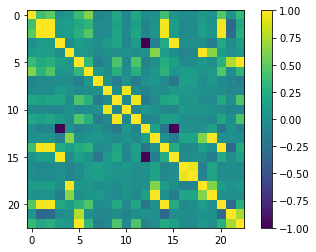

In [13]:
#Show correlation matrix for patterns
r = np.corrcoef(df8.values[:,3:26].astype(float),rowvar=False) # True = variables are rowwise; False = variables are columnwise
# Plot the data:
plt.imshow(r) 
plt.colorbar()
plt.show()#Our last column is our dependent variable. Appears to be highly correlated with 5 (employment)

In [14]:
#Visualize X values
temp_X = df8.drop(['Real GDP Growth (T+1)'], axis = 1).copy()
Y = df8[['Real GDP Growth (T+1)']].copy()
#X1 will be temporal as we will creat dummies with the regions later to enhance prediction.

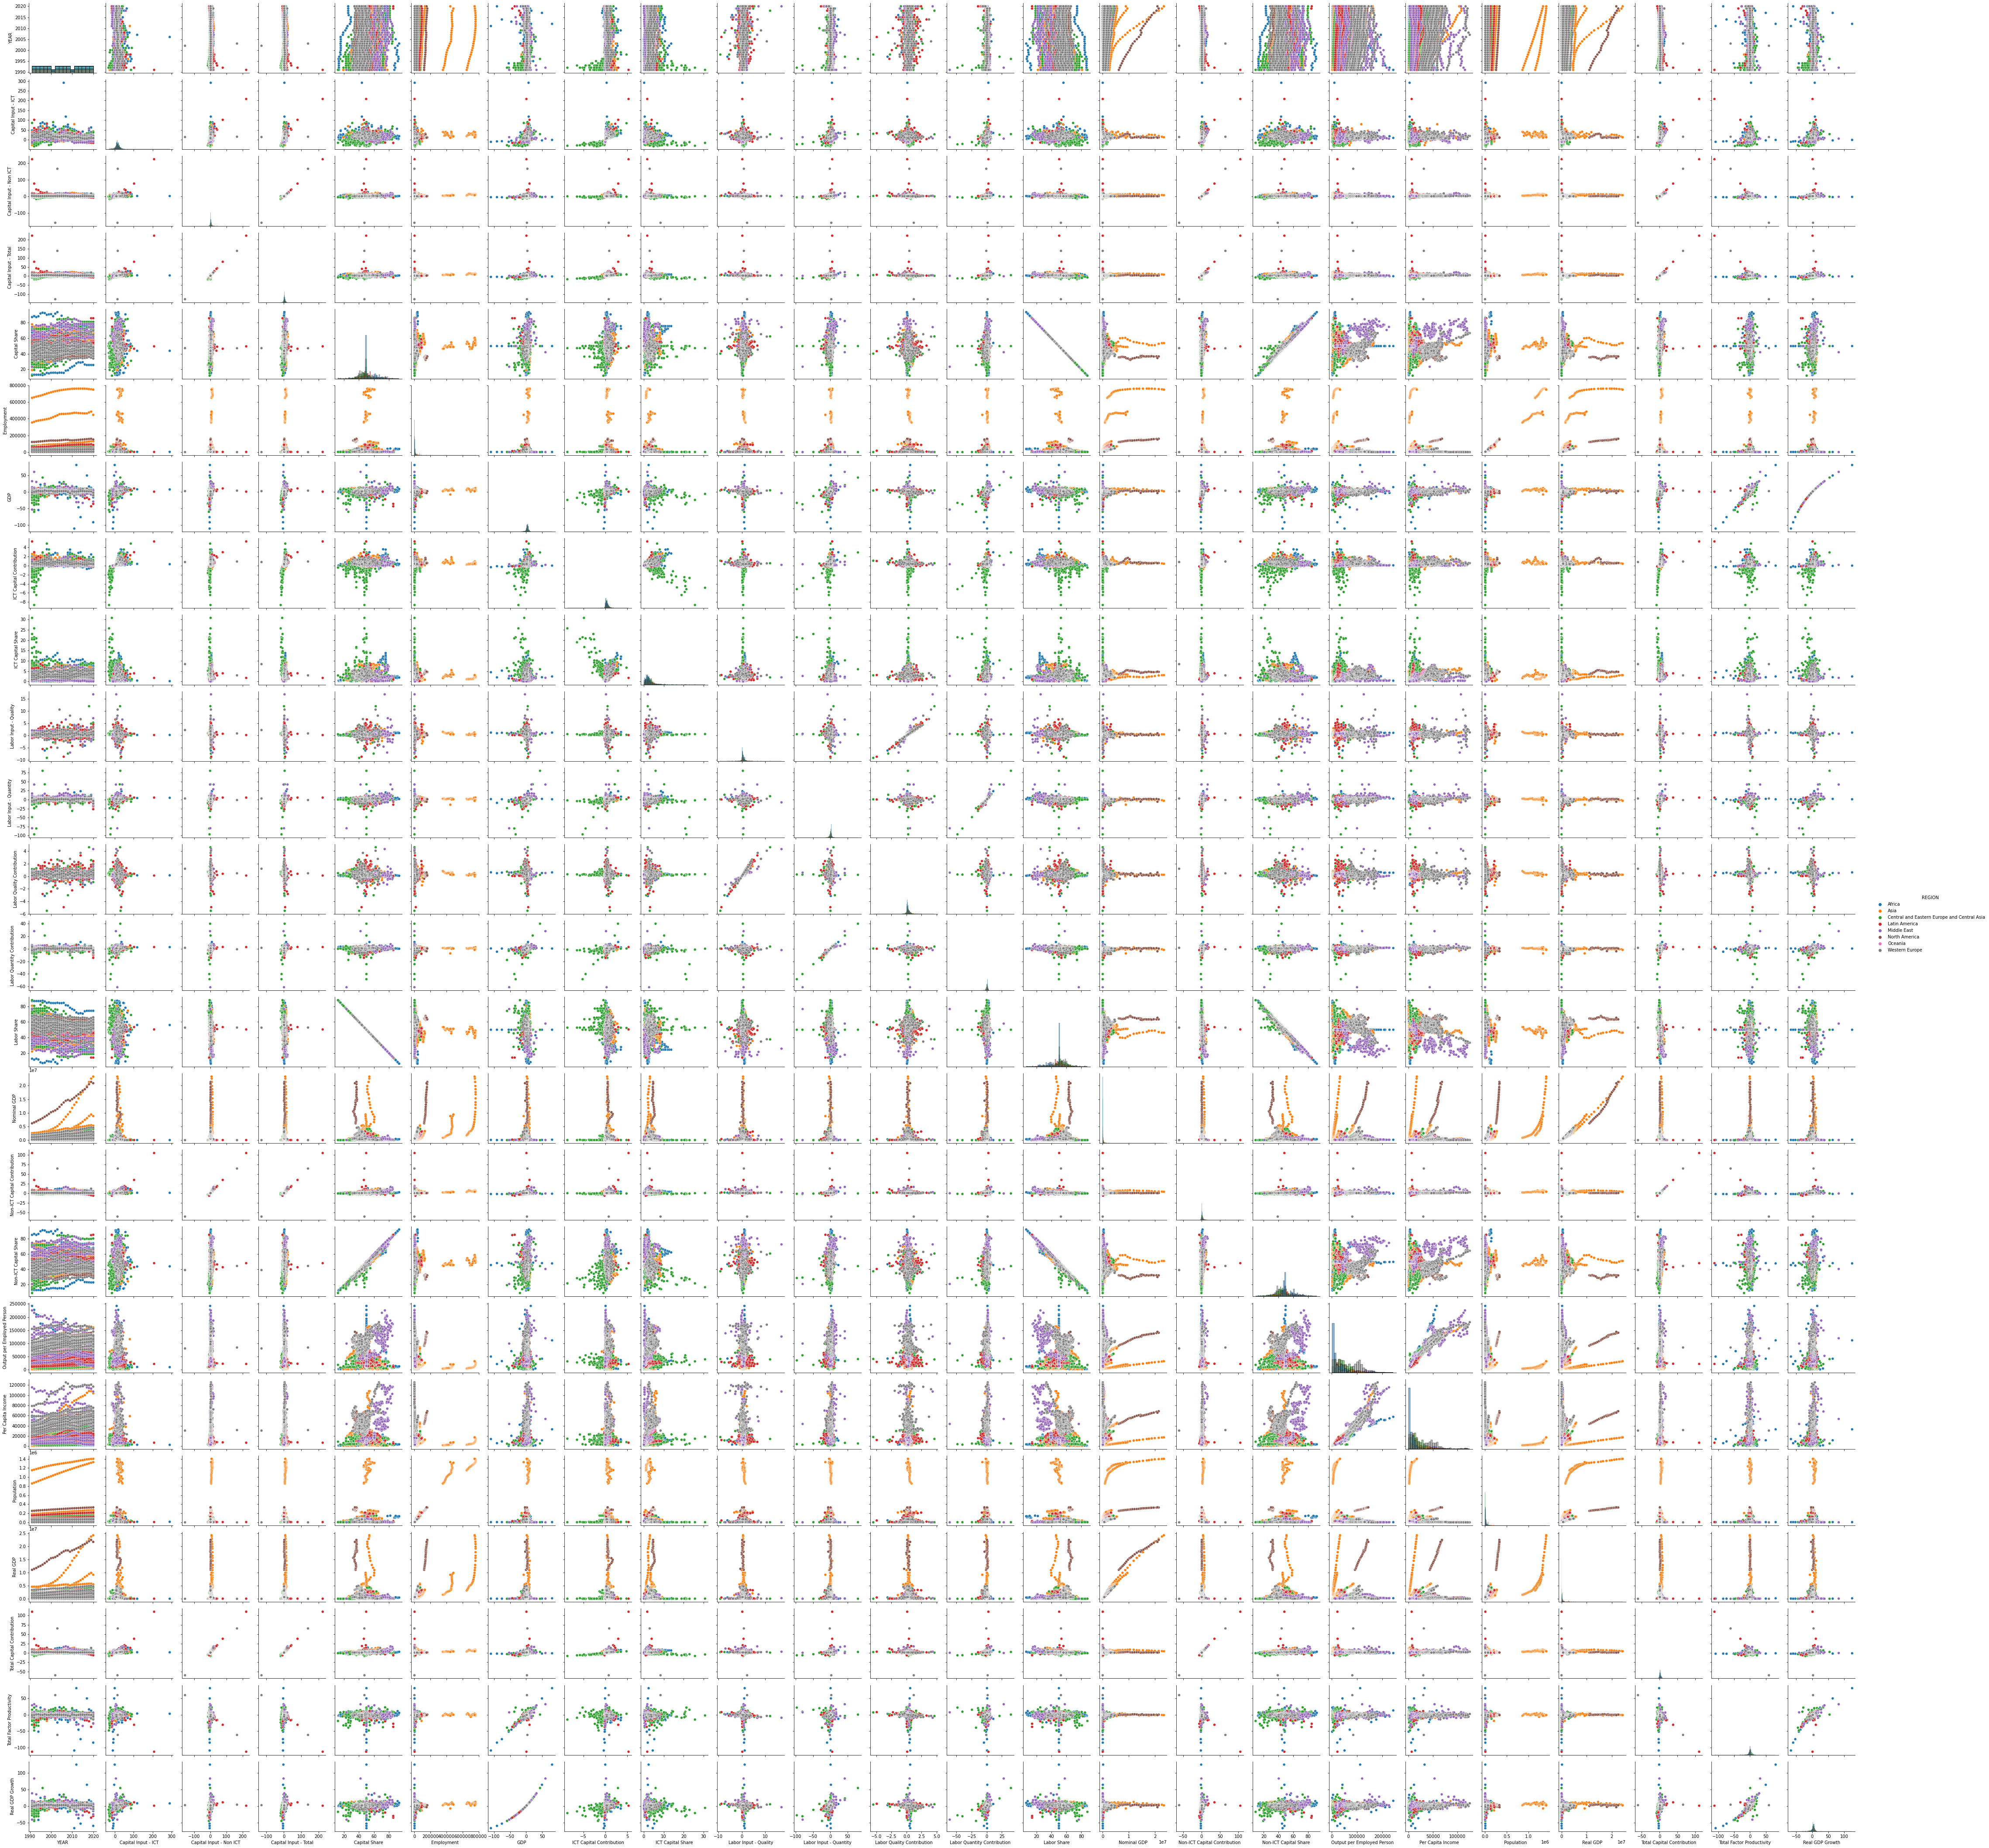

In [57]:
#This takes alot of time, consider not running
g = sns.PairGrid(temp_X, hue = "REGION")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### Make a PCA

Many of our 26 variables are correlated between each other as it can be seen in the correlation plot. Because of this and for simplicity we performed a PCA.

In [15]:
X1 = df8.drop(['Real GDP Growth (T+1)', 'YEAR', 'COUNTRY', 'REGION'], axis = 1).copy()

In [16]:
#Make PCA
def PCA_FF(data):
# The PCA expects normally distributed DATA
# So that is why we z-score the data first
# 1. Z-score the data:
    zDatap = stats.zscore(data)
# 2. Run the PCA:
    pcap = PCA().fit(zDatap)
# 3a. Eigenvalues: Single vector of eigenvalues in decreasing order of magnitude
    eigVals = pcap.explained_variance_
# 3b. Loadings (eigenvectors): Weights per factor in terms of the original data. Where do the
# principal components point, in terms of the 26 variables?
    loadings = pcap.components_
# 3c. Rotated Data: Simply the transformed data - we had all the rows in
# terms of 26 variables (columns), now we have all the rows in terms of 26
# factors ordered by decreasing eigenvalue
    rotatedData = pcap.fit_transform(zDatap)
# 4. We can think of eigenvalues in terms of  the (co)variance explained:
    covarExplained = eigVals/sum(eigVals)*100
    return zDatap, pcap, eigVals, loadings, rotatedData, covarExplained

zDatap, pcap, eigVals, loadings, rotatedData, covarExplained = PCA_FF(X1)

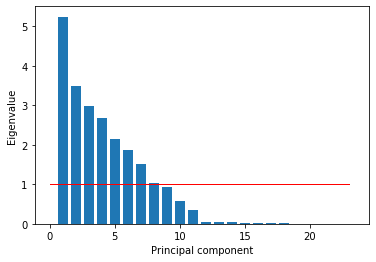

In [17]:
#Scree plot.
acumvar = np.cumsum(covarExplained)
# What a scree plot is: Plotting a bar graph of the sorted Eigenvalues
numClasses = len(X1.values[0,:])
plt.bar(np.linspace(1,numClasses,numClasses),eigVals)
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.plot([0,numClasses],[1,1],color='red',linewidth=1)# Kaiser criterion line
plt.show()
# We note that there are 8 factors that explains most of the data

Using Kaiser criterion we take 8 factors.

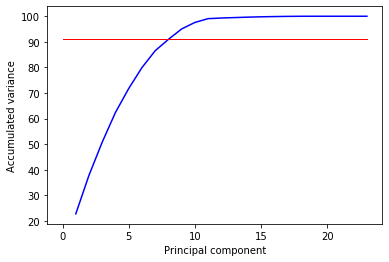

In [18]:
var = np.sum(covarExplained[0:8])
var
#Variance plot
plt.plot(np.linspace(1,numClasses,numClasses), acumvar, color = 'blue') #Acumulated variance
plt.xlabel('Principal component')
plt.ylabel('Accumulated variance')
plt.plot([0,numClasses],[var,var],color='red',linewidth=1)# Kaiser criterion line
plt.show()

Our 8 factors explain around 90% of the variance

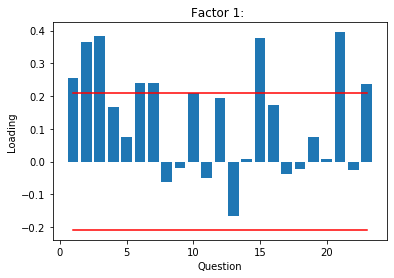

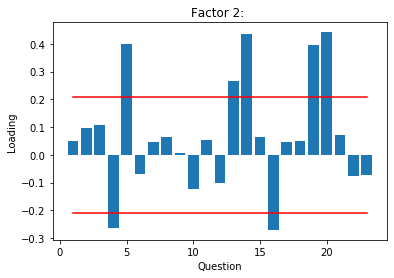

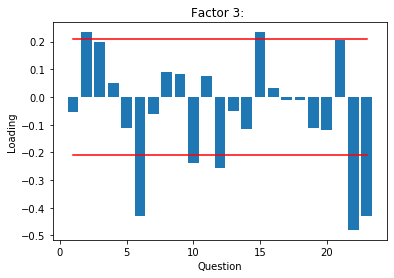

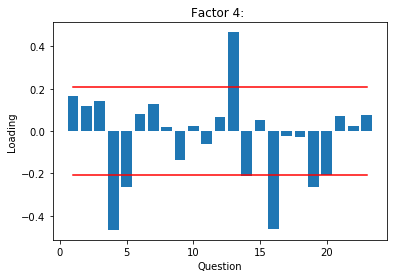

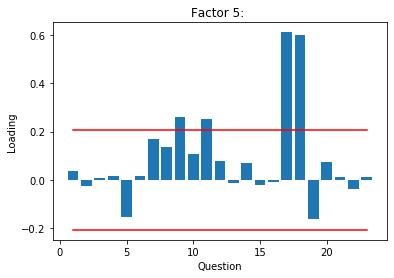

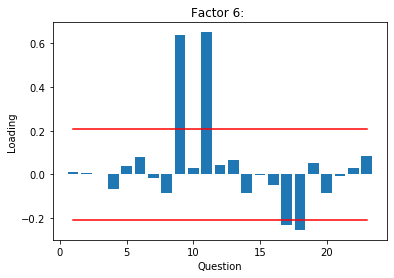

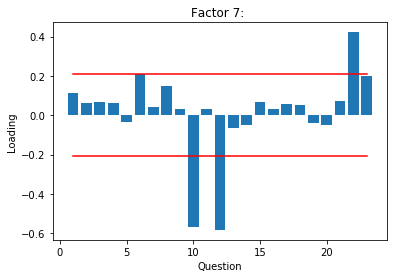

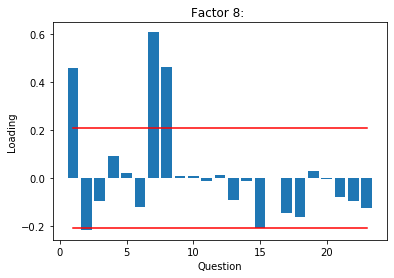

In [19]:
#Interpreting the factors
threshold = (1/len(loadings[0,:]))**0.5

def loadingplot(loadings, data, factors, names = [None]*1000):
    totalfactors = numClasses
    for ii in range(factors):
        plt.bar(np.linspace(1,totalfactors,totalfactors),loadings[ii,:])
        plt.xlabel('Question')
        plt.ylabel('Loading')
        plt.title('Factor {:.0f}: '.format(ii+1) + names[ii])
        plt.plot([1,totalfactors],[threshold,threshold],color='red')
        plt.plot([1,totalfactors],[-threshold,-threshold],color='red')
        plt.show()
loadingplot(loadings, X1, 8, ['','','','','','','',''])

Using a separate excel sheet we named the first four components based on the weights of the 24 independent variables into each pertinent factor. Only the first four factors were names as they are the ones that epxlain most of the variance.

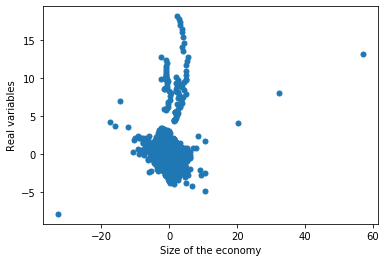

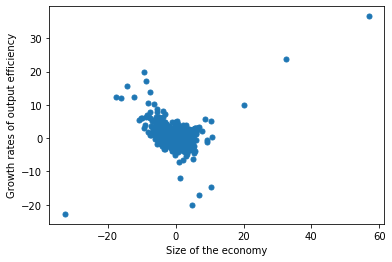

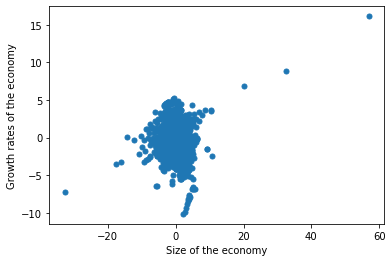

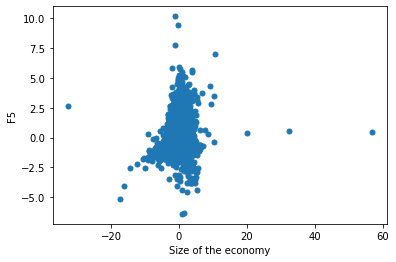

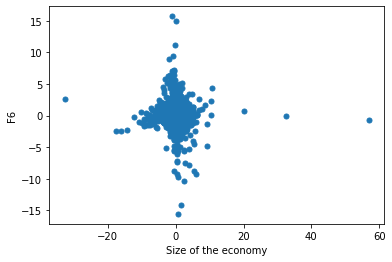

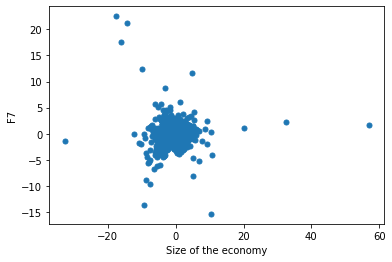

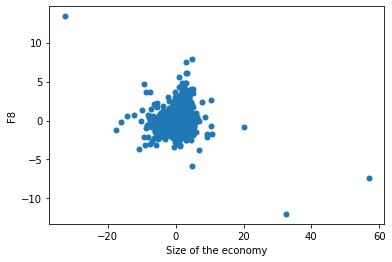

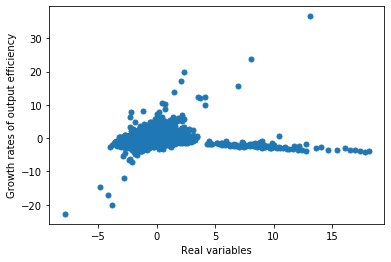

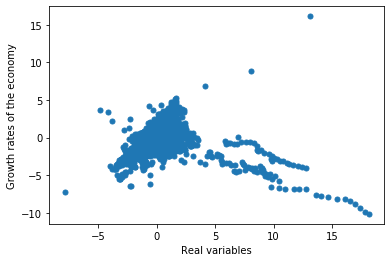

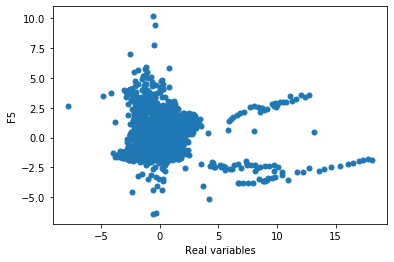

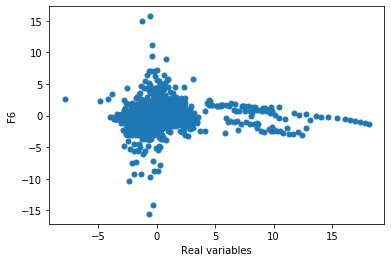

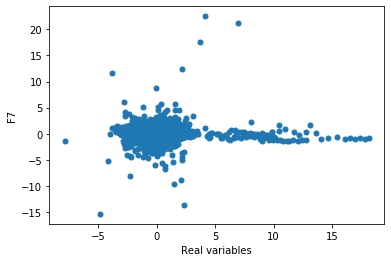

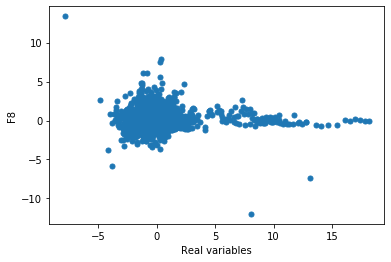

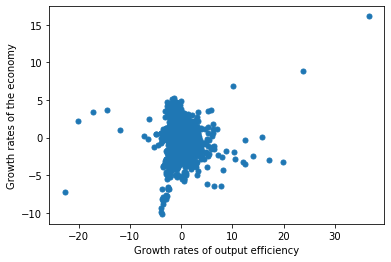

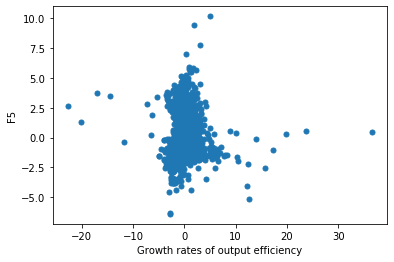

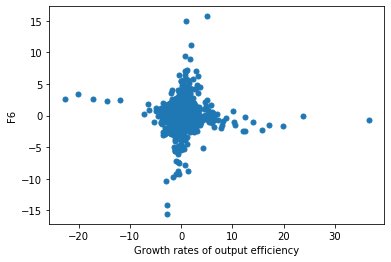

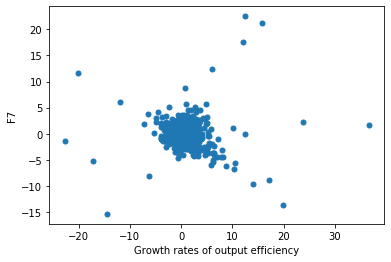

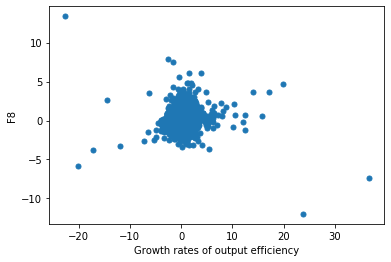

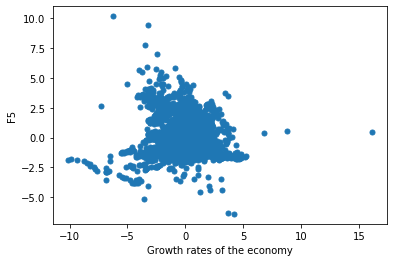

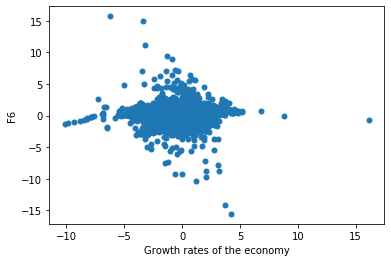

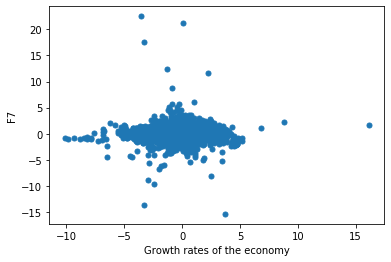

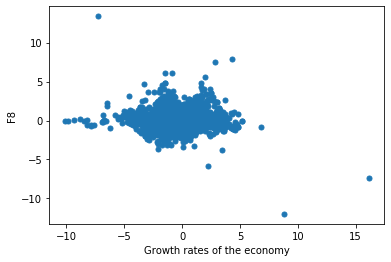

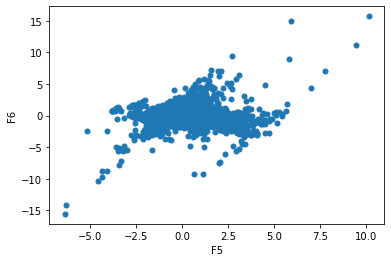

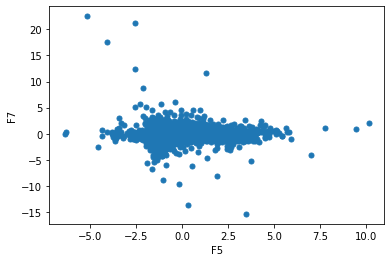

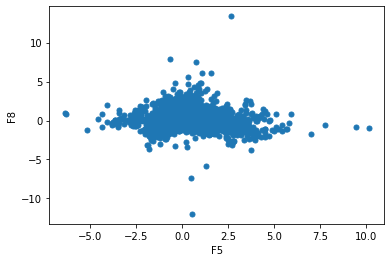

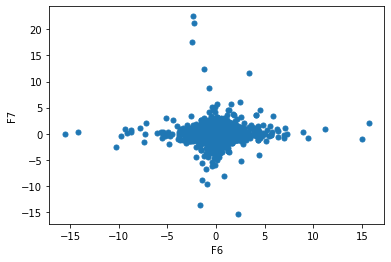

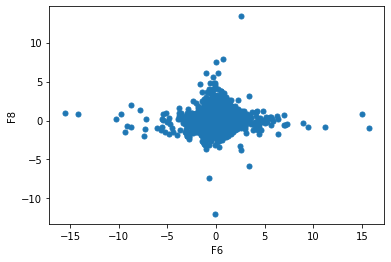

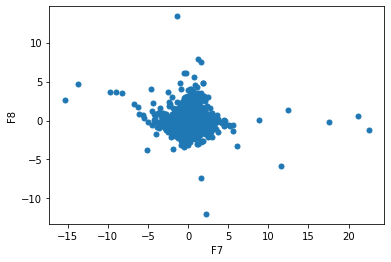

In [20]:
factor_names = ['Size of the economy','Real variables','Growth rates of output efficiency',
                'Growth rates of the economy','F5','F6','F7','F8']

#plots of the relationship between the factors found

def factorplot(rotatedData, factors, names = [None]*1000):
    for ii in range(factors):
        for jj in range(factors-ii-1):
            plt.plot(rotatedData[:,ii],rotatedData[:,ii+jj+1],'o',markersize=5)
            plt.xlabel(names[ii])
            plt.ylabel(names[ii+jj+1]) 
            plt.show()

factorplot(rotatedData, 8, factor_names)

The previous plots show the relationship between the 8 factors.

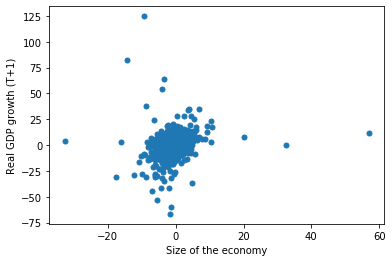

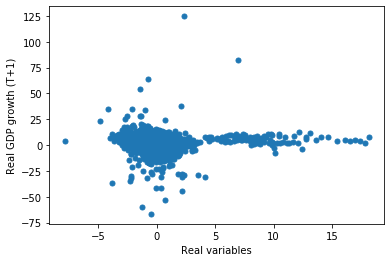

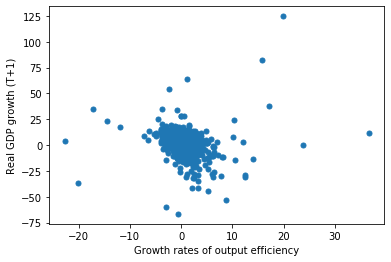

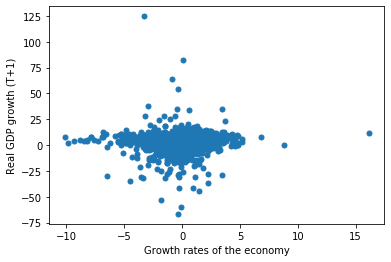

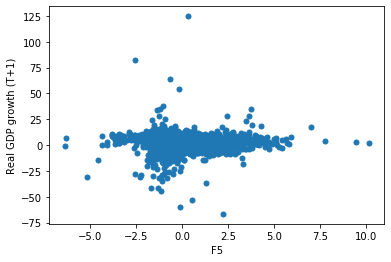

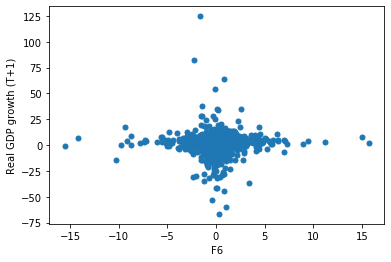

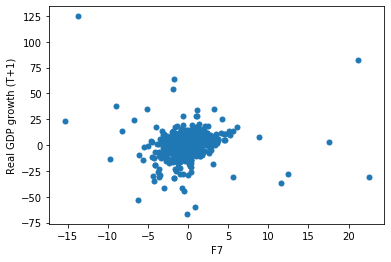

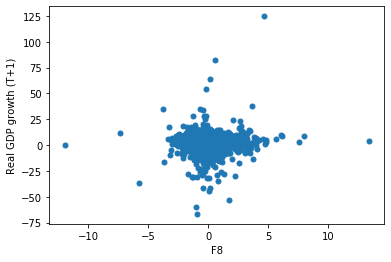

In [23]:
PCA_X1 = pd.DataFrame(rotatedData[:,0:8], columns = factor_names)

for ii in factor_names:
    plt.plot(PCA_X1[ii], Y, 'o', markersize = 5)
    plt.xlabel(ii)
    plt.ylabel('Real GDP growth (T+1)')
    plt.show()

The previous plots show the relationship between Y (Real GDP Growth (T+1)) and our 8 factors. We noticed that none of the factors seems to show a strong realtionship with Y, which means our independet variables are probably not the best to predict GDP Growth. Nevertheless, we continue to explore the problem, as our main objective is to explore the performance metrics.

### Final X variables

In [24]:
#%%Final X values
X_temp = pd.concat([df8.REGION, PCA_X1], axis = 1)
Dummys = pd.get_dummies(X_temp["REGION"])
#Dummys.drop('Africa', inplace = True, axis = 1)#Avoid Dummy trap
X = pd.concat([PCA_X1, Dummys.drop('Africa', axis = 1)], axis = 1)
X_Y = pd.concat([Y,X], axis = 1)
X_Y.head()

Real GDP Growth (T+1)  Size of the economy  Real variables  \
0                  1.600            -1.119928       -0.540331   
1                 -2.102            -0.714811       -0.526882   
2                 -0.900            -1.272794       -0.412716   
3                  3.848            -0.984742       -0.456002   
4                  3.800             0.390121       -0.521711   

   Growth rates of output efficiency  Growth rates of the economy        F5  \
0                           0.410191                    -0.278831 -0.123259   
1                          -0.133251                    -0.047352 -0.106234   
2                           0.691680                    -0.275475 -0.212627   
3                           0.390860                    -0.150059 -0.213774   
4                          -0.808013                     0.525825  0.137753   

         F6        F7        F8  Asia  \
0  1.042202 -1.331701 -0.315742     0   
1  1.111075 -0.619420  0.009083     0   
2  0.984597 -0.926321 -0.067287     0   
3  0.976069 -0.930533  0.062788     0   
4  1.056004 -0.887016  1.339238     0   

   Central and Eastern Europe and Central Asia  Latin America  Middle East  \
0                                            0              0            0   
1                                            0              0            0   
2                                            0              0            0   
3                                            0              0            0   
4                                            0              0            0   

   North America  Oceania  Western Europe  
0              0        0               0  
1              0        0               0  
2              0        0               0  
3              0        0               0  
4              0        0               0

## II. Build the Models

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import metrics

In [26]:
#Estimate performance metrics
def run_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    mae_train = metrics.mean_absolute_error(y_train, model.predict(X_train))
    mae_test = metrics.mean_absolute_error(y_test, model.predict(X_test))
    mse_train = metrics.mean_squared_error(y_train, model.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, model.predict(X_test))
    r2_train = metrics.r2_score(y_train, model.predict(X_train))
    r2_test = metrics.r2_score(y_test, model.predict(X_test))
    meae_train = metrics.median_absolute_error(y_train, model.predict(X_train))
    meae_test = metrics.median_absolute_error(y_test, model.predict(X_test))
    train_scores = [mae_train, mse_train, r2_train, meae_train]
    test_scores = [mae_test, mse_test, r2_test, meae_test]
    return train_scores, test_scores

In [27]:
from scipy.stats import shapiro
def normtest(df): #normality test for the probability distributinos of our performance metrics.
    p_vals = []
    statistics = []
    metrics = []
    reject_null = []
    mean_metric = []
    median_metric = []
    Normal = []
    for column in df:
        metrics.append(column)
        p_vals.append(shapiro(df[column])[1])
        statistics.append(shapiro(df[column])[0])
        mean_metric.append(df[column].mean())
        median_metric.append(df[column].median())
        if shapiro(df[column])[1] < 0.05:
            reject_null.append(1)
            Normal.append('NO')
        else:
            reject_null.append(0)
            Normal.append('YES')
    return pd.DataFrame(list(zip(metrics, p_vals, statistics, reject_null, mean_metric, median_metric, Normal)), columns = ['Metric', 'P_Value', 'Stat', 'reject_null', 'Mean', 'Median','Normal'])

In [28]:
#Plots
def metricsplots(train, test, k, p):#n = number of rows k = number of columns, p = plots
    fig, axs = plt.subplots(1, k, figsize = (20,5))
    end = 1
    for jj in range(k):
        if (end > p): 
            axs[jj].set_visible(False)
            break
        axs[jj].hist(test.iloc[:,end-1], bins = 30, label = 'test')
        axs[jj].vlines(np.mean(test.iloc[:, end-1]), 0 , 100, label = 'avg. test', color = 'red')
        axs[jj].hist(train.iloc[:,end-1], bins = 30, label = "train", alpha = 0.75)
        axs[jj].vlines(np.mean(train.iloc[:, end-1]), 0 , 100, label = 'avg. train', color = 'black')
        axs[jj].set_title(train.columns[end-1])
        axs[jj].legend()
        end = end + 1

In the following lines we will. build the three chosen models, OLS, Neural Network and Random Forest. Due to the high duration of time that the boostraping procedure in combination with fitting the model has, we will test each of the three models only in three train split sizes (75%, 50% and 90%)

### 1. OLS

##### 75% train size

In [52]:
%%time
reg = LinearRegression()
train_metrics_21 = []
test_metrics_21 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.75)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics(X_train, y_train, X_test, y_test, reg)
    train_metrics_21.append(temp_matrix[0])
    test_metrics_21.append(temp_matrix[1])

Wall time: 37.1 s


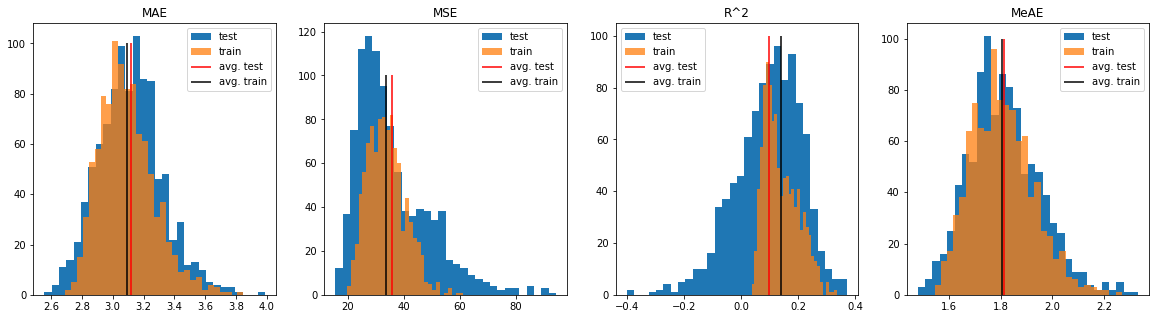

In [53]:
train_df_21 = pd.DataFrame(train_metrics_21, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_21 = pd.DataFrame(test_metrics_21, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_21, test = test_df_21, k=4, p=4)

#### {
#### Extra assesment for futher research:
The previous plots show an interesting distribution in our performance metrics, as we visualy see a convergence to a normal distribution in all the statistics, these distributions could also allow us to make some hypothesis tests.
The case of R^2 might be the one with most relevance to make an hyposthesis tests. Nevetheless it is not optimal, as the R^2 is prone to increase with overfitting, which is something we do not want. Nevertheless, we could use some hypothesis tests to asses the following for example:

$$
H_0: R^2 = 0
\\
H_1: R^2 \neq 0
$$

This particular test would allow us to asses if our models is actually explaining some of the variance or it is simply due to randomness. By specifying a confidence interval with a chosen significance level we could make the test.

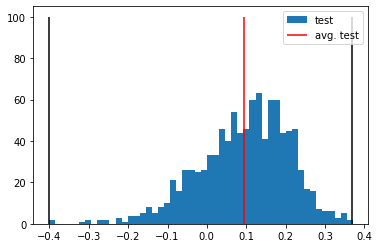

In [57]:
alpha = 0.05
plt.hist(test_df_21.iloc[:,2], bins = 50, label = 'test')
plt.vlines(np.mean(test_df_21.iloc[:, 2]), 0 , 100, label = 'avg. test', color = 'red')
plt.vlines(np.percentile(test_df_21.iloc[:, 2], (alpha/2)), 0 , 100, color = 'black')
plt.vlines(np.percentile(test_df_21.iloc[:, 2], (100-(alpha/2))), 0 , 100, color = 'black')
#plt.set_title(test_df.columns[2])
plt.legend()

For simplicity and only to help develop the idea, lets assume that the sample probability distribution is the population probability distributino of the R^2 performance metric of this OLS model. With this bold assumption, we can not reject that our R^2 is different than zero within the 95% confidence interval. The problems with the R^2 outlined above make it difficult to make assesments on the actual model. Nevertheless, exploring this idea might be useful in further research in order to asses if this would actually be helpful in other performance metrics.

If it was found that it is useful, the previous procedure would allow us to have a more objective statistical assesment of the performance of our models instead than just relying on the average performance metrics when condunction a k-fold crosss validation, which is in most ocassions arbitrarlily established when choosing the number of k-fold iterations, and where hypotheisis tests are not applied.

#### }

In [58]:
normtest(train_df_21)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  9.205892e-13  0.972719            1   3.090803   3.068364     NO
1    MSE  1.745371e-10  0.980016            1  33.792294  33.362348     NO
2    R^2  2.560667e-18  0.947849            1   0.139296   0.123846     NO
3   MeAE  4.193933e-09  0.983767            1   1.805895   1.794290     NO

In [59]:
normtest(test_df_21)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  8.564572e-06  0.991001            1   3.115767   3.113509     NO
1    MSE  8.950185e-25  0.902114            1  35.959213  32.358216     NO
2    R^2  6.095278e-11  0.978667            1   0.095242   0.109807     NO
3   MeAE  1.310450e-08  0.984998            1   1.812945   1.801608     NO

None of the distributions are normal.

##### 50% train size

Wall time: 36.8 s


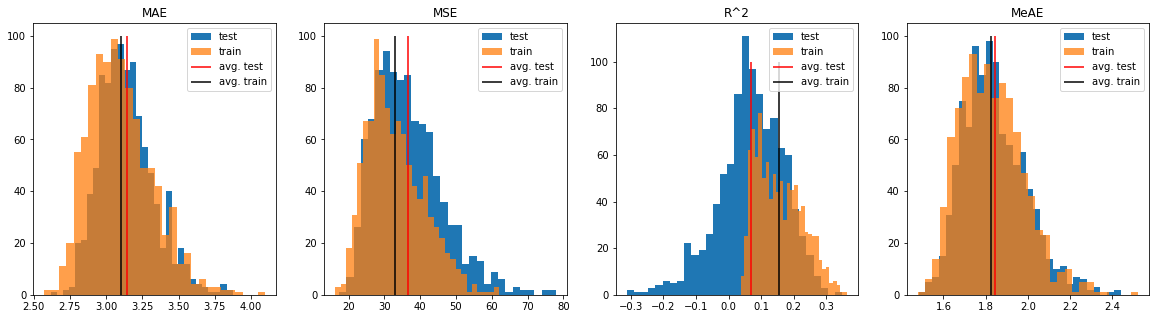

In [63]:
%%time
#train size = 0.5
train_metrics_22 = []
test_metrics_22 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.5)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics(X_train, y_train, X_test, y_test, reg)
    train_metrics_22.append(temp_matrix[0])
    test_metrics_22.append(temp_matrix[1])
train_df_22 = pd.DataFrame(train_metrics_22, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_22 = pd.DataFrame(test_metrics_22, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_22, test = test_df_22, k=4, p=4)

In [64]:
normtest(train_df_22)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  1.113472e-12  0.973010            1   3.101392   3.074704     NO
1    MSE  2.151977e-14  0.966542            1  33.015578  31.650126     NO
2    R^2  1.729175e-16  0.957288            1   0.155273   0.145241     NO
3   MeAE  2.111761e-11  0.977252            1   1.827364   1.815091     NO

In [65]:
normtest(test_df_22)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  4.958170e-12  0.975222            1   3.144658   3.121891     NO
1    MSE  3.607644e-18  0.948668            1  36.669235  35.437068     NO
2    R^2  3.932829e-08  0.986134            1   0.069497   0.072366     NO
3   MeAE  1.775911e-12  0.973715            1   1.842661   1.824335     NO

None of the distributions are normal

##### 90% train size

Wall time: 32.7 s


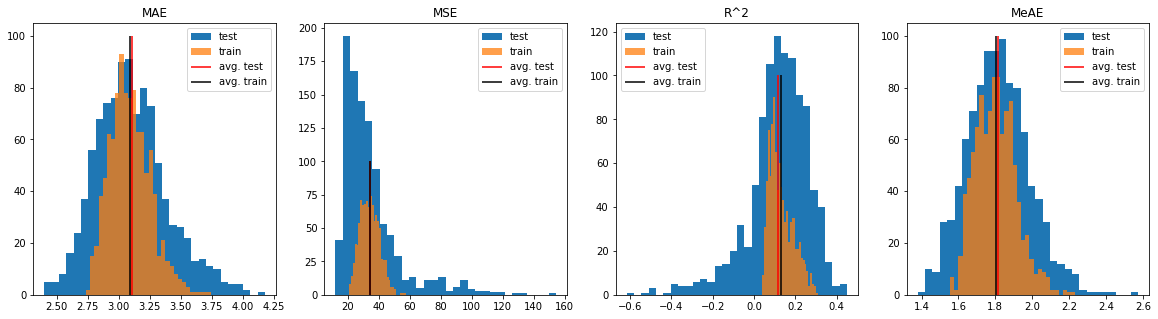

In [66]:
%%time
#train size = 0.9
train_metrics_23 = []
test_metrics_23 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.9)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics(X_train, y_train, X_test, y_test, reg)
    train_metrics_23.append(temp_matrix[0])
    test_metrics_23.append(temp_matrix[1])
train_df_23 = pd.DataFrame(train_metrics_23, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_23 = pd.DataFrame(test_metrics_23, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_23, test = test_df_23, k=4, p=4)

In [67]:
normtest(train_df_23)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  7.586521e-10  0.981808            1   3.092283   3.077027     NO
1    MSE  2.424692e-06  0.989957            1  34.215504  34.069231     NO
2    R^2  1.441999e-19  0.940597            1   0.132204   0.119255     NO
3   MeAE  5.522743e-09  0.984069            1   1.802717   1.796899     NO

In [68]:
normtest(test_df_23)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  5.176253e-09  0.983998            1   3.103658   3.079635     NO
1    MSE  1.757363e-34  0.782245            1  34.589480  29.563261     NO
2    R^2  1.400523e-19  0.940520            1   0.118089   0.134115     NO
3   MeAE  8.265492e-05  0.992742            1   1.814415   1.809722     NO

None of the distributions were normal in any train split in the case of OLS according to the normality test defined.

General notes on the performance metrics: OLS appears not to be a good model for predicting Real GDP Growth the next year with the current independet variables. High errors (taking into account we are estimating percent change) and low variance explained.

### Neural Network

In [29]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [43]:
def neural (X, y, validation, nodes = 50, layers = 2, output = 1, epochs = 1, columns = 2, 
            activation = 'linear', loss = 'binary_crossentropy', 
            metrics = ['mean_squared_error','mean_absolute_error'],
           optimizer = 'adam'):
    nnmodel = Sequential()
    if (layers >= 1):
        nnmodel.add(Dense(nodes, activation = 'relu', input_shape = (X.shape[1],)))#first layer
    if (layers >= 2):
        nnmodel.add(Dense(nodes, activation = 'relu'))#second layer
    if (layers >= 3):
        nnmodel.add(Dense(nodes, activation = 'relu'))#third layer
    if (layers >= 4):
        nnmodel.add(Dense(nodes, activation = 'relu'))#fourth layer
    if (layers >= 5):
        nnmodel.add(Dense(nodes, activation = 'relu'))#fifth layer
    if (layers >= 6):
        nnmodel.add(Dense(nodes, activation = 'relu'))#sixth layer
    if (layers >= 7):
        nnmodel.add(Dense(nodes, activation = 'relu'))#seventh layer
    if (layers >= 8):
        nnmodel.add(Dense(nodes, activation = 'relu'))#eight layer 
    nnmodel.add(Dense(output, activation = activation))#output layer

    nnmodel.compile(optimizer = optimizer, loss = loss, metrics = metrics)

    nnmodel.fit(X, y, validation_data = validation, epochs = epochs)
    return nnmodel

def run_metrics2(X_train, y_train, X_test, y_test):
    model = neural(X = X_train, y = y_train, validation = (X_test, y_test), layers = 1)
    mae_train = metrics.mean_absolute_error(y_train, model.predict(X_train))
    mae_test = metrics.mean_absolute_error(y_test, model.predict(X_test))
    mse_train = metrics.mean_squared_error(y_train, model.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, model.predict(X_test))
    r2_train = metrics.r2_score(y_train, model.predict(X_train))
    r2_test = metrics.r2_score(y_test, model.predict(X_test))
    meae_train = metrics.median_absolute_error(y_train, model.predict(X_train))
    meae_test = metrics.median_absolute_error(y_test, model.predict(X_test))
    train_scores = [mae_train, mse_train, r2_train, meae_train]
    test_scores = [mae_test, mse_test, r2_test, meae_test]
    return train_scores, test_scores

##### 75% train size

In [31]:
%%time
train_metrics_31 = []
test_metrics_31 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.75)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics2(X_train, y_train, X_test, y_test)
    train_metrics_31.append(temp_matrix[0])
    test_metrics_31.append(temp_matrix[1])

90/90 [==============================] - 1s 4ms/step - loss: 10.0149 - mean_squared_error: 49.2285 - mean_absolute_error: 4.9439 - val_loss: -10.1724 - val_mean_squared_error: 36.6791 - val_mean_absolute_error: 4.6782


90/90 [==============================] - 1s 3ms/step - loss: -5.2861 - mean_squared_error: 44.3980 - mean_absolute_error: 4.6107 - val_loss: -18.3735 - val_mean_squared_error: 39.1236 - val_mean_absolute_error: 4.3201


90/90 [==============================] - 1s 7ms/step - loss: -14.9865 - mean_squared_error: 36.8086 - mean_absolute_error: 4.3230 - val_loss: -26.9324 - val_mean_squared_error: 43.9665 - val_mean_absolute_error: 4.0142


90/90 [==============================] - 1s 4ms/step - loss: -18.8983 - mean_squared_error: 38.5870 - mean_absolute_error: 4.3618 - val_loss: -33.3311 - val_mean_squared_error: 32.6540 - val_mean_absolute_error: 3.9961


90/90 [==============================] - 1s 4ms/step - loss: 1.7664 - mean_squared_error: 62.2238 - mean_absolute_error: 4.9490 - val_loss: -14.9271 - val_mean_squared_error: 35.9240 - val_mean_absolute_error: 4.5230


90/90 [==============================] - 1s 4ms/step - loss: -20.4052 - mean_squared_error: 41.0130 - mean_absolute_error: 4.3221 - val_loss: -29.5621 - val_mean_squared_error: 36.4787 - val_mean_absolute_error: 3.9168


90/90 [==============================] - 1s 4ms/step - loss: 17.9479 - mean_squared_error: 47.7410 - mean_absolute_error: 4.8752 - val_loss: -9.7375 - val_mean_squared_error: 41.1577 - val_mean_absolute_error: 4.4492


90/90 [==============================] - 1s 4ms/step - loss: 20.8574 - mean_squared_error: 55.1882 - mean_absolute_error: 5.0847 - val_loss: -4.7979 - val_mean_squared_error: 46.1488 - val_mean_absolute_error: 4.8218


90/90 [==============================] - 1s 4ms/step - loss: -24.6116 - mean_squared_error: 38.1018 - mean_absolute_error: 4.2886 - val_loss: -34.5218 - val_mean_squared_error: 33.0896 - val_mean_absolute_error: 4.0415


90/90 [==============================] - 1s 4ms/step - loss: -13.7111 - mean_squared_error: 42.6176 - mean_absolute_error: 4.5154 - val_loss: -28.2429 - val_mean_squared_error: 29.6034 - val_mean_absolute_error: 4.0512


90/90 [==============================] - 1s 3ms/step - loss: -1.1258 - mean_squared_error: 47.1992 - mean_absolute_error: 4.6937 - val_loss: -20.1601 - val_mean_squared_error: 39.8565 - val_mean_absolute_error: 4.4811


90/90 [==============================] - 1s 3ms/step - loss: -12.1256 - mean_squared_error: 34.9253 - mean_absolute_error: 4.3289 - val_loss: -24.1520 - val_mean_squared_error: 39.3742 - val_mean_absolute_error: 4.3279


90/90 [==============================] - 1s 4ms/step - loss: -0.6600 - mean_squared_error: 43.4211 - mean_absolute_error: 4.5663 - val_loss: -21.6562 - val_mean_squared_error: 38.2408 - val_mean_absolute_error: 4.3103


90/90 [==============================] - 1s 4ms/step - loss: -24.9855 - mean_squared_error: 37.1362 - mean_absolute_error: 4.2722 - val_loss: -32.6569 - val_mean_squared_error: 28.6434 - val_mean_absolute_error: 3.8606


90/90 [==============================] - 1s 4ms/step - loss: -20.7053 - mean_squared_error: 39.1412 - mean_absolute_error: 4.2573 - val_loss: -32.7126 - val_mean_squared_error: 69.9594 - val_mean_absolute_error: 4.2384


90/90 [==============================] - 1s 4ms/step - loss: 1.2962 - mean_squared_error: 42.9889 - mean_absolute_error: 4.6913 - val_loss: -17.7915 - val_mean_squared_error: 40.0795 - val_mean_absolute_error: 4.4164


90/90 [==============================] - 1s 4ms/step - loss: -3.6517 - mean_squared_error: 45.6272 - mean_absolute_error: 4.6203 - val_loss: -27.0548 - val_mean_squared_error: 45.2589 - val_mean_absolute_error: 4.4314


90/90 [==============================] - 1s 4ms/step - loss: 4.0919 - mean_squared_error: 47.3799 - mean_absolute_error: 4.7636 - val_loss: -11.2735 - val_mean_squared_error: 43.2772 - val_mean_absolute_error: 4.5523


90/90 [==============================] - 1s 4ms/step - loss: 31.8690 - mean_squared_error: 53.6854 - mean_absolute_error: 5.0706 - val_loss: 16.6673 - val_mean_squared_error: 40.3359 - val_mean_absolute_error: 4.8214


90/90 [==============================] - 1s 4ms/step - loss: -13.5719 - mean_squared_error: 40.6463 - mean_absolute_error: 4.5363 - val_loss: -25.6221 - val_mean_squared_error: 30.2252 - val_mean_absolute_error: 4.0137


90/90 [==============================] - 1s 4ms/step - loss: 10.5547 - mean_squared_error: 43.5176 - mean_absolute_error: 4.8501 - val_loss: -16.3360 - val_mean_squared_error: 38.6386 - val_mean_absolute_error: 4.3976


90/90 [==============================] - 1s 4ms/step - loss: 39.0912 - mean_squared_error: 49.9849 - mean_absolute_error: 5.3674 - val_loss: 25.1983 - val_mean_squared_error: 40.3720 - val_mean_absolute_error: 4.9902


90/90 [==============================] - 1s 4ms/step - loss: 32.7798 - mean_squared_error: 55.2793 - mean_absolute_error: 5.1855 - val_loss: 19.3723 - val_mean_squared_error: 41.0295 - val_mean_absolute_error: 4.5809


90/90 [==============================] - 1s 4ms/step - loss: -8.4701 - mean_squared_error: 43.9508 - mean_absolute_error: 4.4441 - val_loss: -21.7291 - val_mean_squared_error: 36.6548 - val_mean_absolute_error: 4.2602


90/90 [==============================] - 1s 4ms/step - loss: -4.1208 - mean_squared_error: 43.6901 - mean_absolute_error: 4.6092 - val_loss: -20.2537 - val_mean_squared_error: 30.8440 - val_mean_absolute_error: 4.1542


90/90 [==============================] - 1s 4ms/step - loss: -12.8604 - mean_squared_error: 40.1316 - mean_absolute_error: 4.3467 - val_loss: -25.8884 - val_mean_squared_error: 42.3734 - val_mean_absolute_error: 4.1901


90/90 [==============================] - 1s 4ms/step - loss: 2.4499 - mean_squared_error: 47.6689 - mean_absolute_error: 4.6930 - val_loss: -21.5427 - val_mean_squared_error: 29.7803 - val_mean_absolute_error: 4.1224
Wall time: 28min 21s


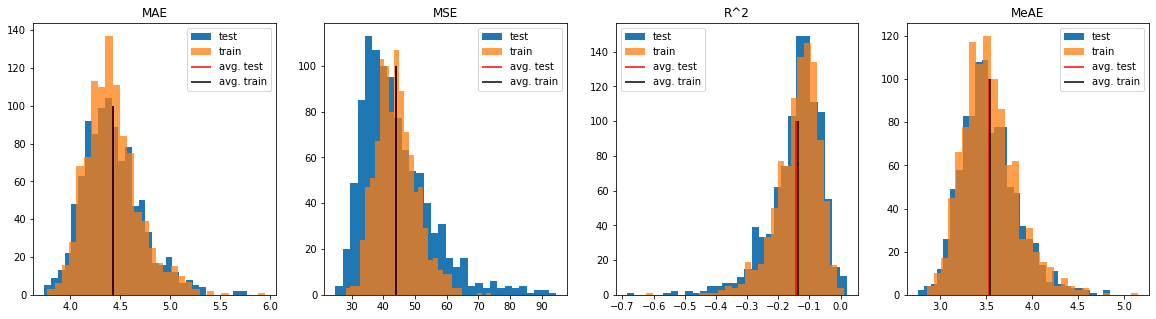

In [32]:
train_df_31 = pd.DataFrame(train_metrics_31, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_31 = pd.DataFrame(test_metrics_31, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_31, test = test_df_31, k=4, p=4)

In [33]:
normtest(train_df_31)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  5.215163e-15  0.963984            1   4.426092   4.397244     NO
1    MSE  1.075718e-10  0.979402            1  44.140103  43.691026     NO
2    R^2  8.117364e-21  0.932634            1  -0.137716  -0.125764     NO
3   MeAE  1.406652e-14  0.965788            1   3.539779   3.508562     NO

In [34]:
normtest(test_df_31)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  2.297746e-13  0.970535            1   4.424850   4.392387     NO
1    MSE  4.315955e-24  0.908008            1  44.063202  41.590764     NO
2    R^2  4.840327e-23  0.916535            1  -0.144180  -0.129211     NO
3   MeAE  1.075097e-12  0.972956            1   3.536251   3.498751     NO

None of the distributions are normal

##### 50% train size

In [44]:
%%time
train_metrics_32 = []
test_metrics_32 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.50)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics2(X_train, y_train, X_test, y_test)
    train_metrics_32.append(temp_matrix[0])
    test_metrics_32.append(temp_matrix[1])

60/60 [==============================] - 1s 5ms/step - loss: -21.5162 - mean_squared_error: 41.0077 - mean_absolute_error: 4.2879 - val_loss: -31.4222 - val_mean_squared_error: 45.2632 - val_mean_absolute_error: 4.1760


60/60 [==============================] - 1s 6ms/step - loss: -12.7574 - mean_squared_error: 46.6601 - mean_absolute_error: 4.4434 - val_loss: -31.1905 - val_mean_squared_error: 45.5328 - val_mean_absolute_error: 4.2984


60/60 [==============================] - 1s 6ms/step - loss: -1.0219 - mean_squared_error: 52.5062 - mean_absolute_error: 4.6247 - val_loss: -7.4119 - val_mean_squared_error: 33.4507 - val_mean_absolute_error: 4.3427


60/60 [==============================] - 1s 7ms/step - loss: 8.2325 - mean_squared_error: 38.2524 - mean_absolute_error: 4.8088 - val_loss: -3.2898 - val_mean_squared_error: 34.8174 - val_mean_absolute_error: 4.5670


60/60 [==============================] - 1s 9ms/step - loss: -5.2592 - mean_squared_error: 45.6116 - mean_absolute_error: 4.5638 - val_loss: -23.6546 - val_mean_squared_error: 36.0910 - val_mean_absolute_error: 4.3431


60/60 [==============================] - 1s 15ms/step - loss: 5.8966 - mean_squared_error: 43.2444 - mean_absolute_error: 4.7848 - val_loss: -3.1870 - val_mean_squared_error: 54.9373 - val_mean_absolute_error: 4.6881


60/60 [==============================] - 1s 7ms/step - loss: 30.0150 - mean_squared_error: 51.6820 - mean_absolute_error: 5.0302 - val_loss: 23.5854 - val_mean_squared_error: 51.1556 - val_mean_absolute_error: 4.8348


60/60 [==============================] - 1s 6ms/step - loss: -1.0427 - mean_squared_error: 47.0822 - mean_absolute_error: 4.7999 - val_loss: -18.6919 - val_mean_squared_error: 38.4813 - val_mean_absolute_error: 4.3811


60/60 [==============================] - 1s 6ms/step - loss: -18.1048 - mean_squared_error: 44.9804 - mean_absolute_error: 4.4172 - val_loss: -26.5855 - val_mean_squared_error: 41.6144 - val_mean_absolute_error: 4.0826


60/60 [==============================] - 1s 6ms/step - loss: -22.7293 - mean_squared_error: 49.9447 - mean_absolute_error: 4.4522 - val_loss: -28.3076 - val_mean_squared_error: 44.0823 - val_mean_absolute_error: 4.3086


60/60 [==============================] - 1s 6ms/step - loss: 9.0723 - mean_squared_error: 49.6096 - mean_absolute_error: 4.8029 - val_loss: -6.2441 - val_mean_squared_error: 41.7432 - val_mean_absolute_error: 4.6450


60/60 [==============================] - 1s 6ms/step - loss: 4.7092 - mean_squared_error: 40.9099 - mean_absolute_error: 4.6779 - val_loss: -14.8670 - val_mean_squared_error: 64.7580 - val_mean_absolute_error: 4.8064


60/60 [==============================] - 1s 6ms/step - loss: 0.5199 - mean_squared_error: 43.6919 - mean_absolute_error: 4.7197 - val_loss: -19.2051 - val_mean_squared_error: 45.7936 - val_mean_absolute_error: 4.3619


60/60 [==============================] - 1s 6ms/step - loss: 6.0702 - mean_squared_error: 41.9194 - mean_absolute_error: 4.6497 - val_loss: -3.4445 - val_mean_squared_error: 45.0389 - val_mean_absolute_error: 4.5437


60/60 [==============================] - 1s 7ms/step - loss: -1.7616 - mean_squared_error: 44.8268 - mean_absolute_error: 4.5883 - val_loss: -15.2183 - val_mean_squared_error: 42.2606 - val_mean_absolute_error: 4.4977


60/60 [==============================] - 1s 6ms/step - loss: -7.8504 - mean_squared_error: 52.6074 - mean_absolute_error: 4.7082 - val_loss: -20.3812 - val_mean_squared_error: 37.2708 - val_mean_absolute_error: 4.1031


60/60 [==============================] - 1s 7ms/step - loss: 13.7554 - mean_squared_error: 41.6424 - mean_absolute_error: 4.7265 - val_loss: -4.8254 - val_mean_squared_error: 47.4593 - val_mean_absolute_error: 4.4652


60/60 [==============================] - 1s 6ms/step - loss: 8.6925 - mean_squared_error: 53.4419 - mean_absolute_error: 4.9875 - val_loss: -9.4540 - val_mean_squared_error: 46.3175 - val_mean_absolute_error: 4.6968


60/60 [==============================] - 1s 7ms/step - loss: 8.9581 - mean_squared_error: 64.5378 - mean_absolute_error: 5.0717 - val_loss: -13.8312 - val_mean_squared_error: 45.6479 - val_mean_absolute_error: 4.5774


60/60 [==============================] - 1s 7ms/step - loss: -20.6436 - mean_squared_error: 41.7264 - mean_absolute_error: 4.4347 - val_loss: -34.6582 - val_mean_squared_error: 52.7015 - val_mean_absolute_error: 4.3586


60/60 [==============================] - 1s 6ms/step - loss: 3.1724 - mean_squared_error: 44.5057 - mean_absolute_error: 4.6094 - val_loss: -13.6624 - val_mean_squared_error: 42.8050 - val_mean_absolute_error: 4.5846


60/60 [==============================] - 1s 6ms/step - loss: 36.3160 - mean_squared_error: 53.7211 - mean_absolute_error: 5.2886 - val_loss: 28.2387 - val_mean_squared_error: 45.3149 - val_mean_absolute_error: 5.0408


60/60 [==============================] - 1s 6ms/step - loss: -10.8478 - mean_squared_error: 35.0226 - mean_absolute_error: 4.2966 - val_loss: -24.6363 - val_mean_squared_error: 41.4194 - val_mean_absolute_error: 4.2932


60/60 [==============================] - 1s 7ms/step - loss: 1.5579 - mean_squared_error: 48.5734 - mean_absolute_error: 4.7391 - val_loss: -15.3232 - val_mean_squared_error: 41.8753 - val_mean_absolute_error: 4.6303


60/60 [==============================] - 1s 6ms/step - loss: 31.2474 - mean_squared_error: 83.7156 - mean_absolute_error: 5.4090 - val_loss: 31.4507 - val_mean_squared_error: 50.7284 - val_mean_absolute_error: 5.0265


60/60 [==============================] - 1s 6ms/step - loss: 11.8347 - mean_squared_error: 52.7933 - mean_absolute_error: 4.9771 - val_loss: -10.7466 - val_mean_squared_error: 31.5903 - val_mean_absolute_error: 4.2641


60/60 [==============================] - 1s 6ms/step - loss: -10.0681 - mean_squared_error: 49.6785 - mean_absolute_error: 4.4845 - val_loss: -25.3742 - val_mean_squared_error: 39.0676 - val_mean_absolute_error: 4.3143
Wall time: 33min 28s


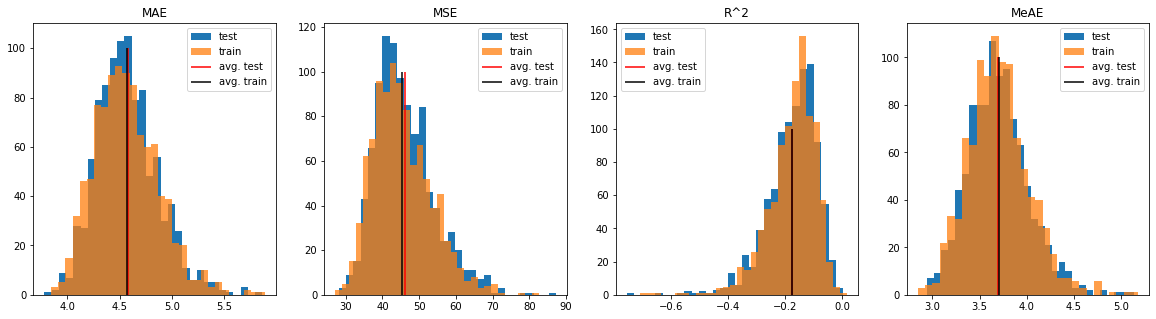

In [45]:
train_df_32 = pd.DataFrame(train_metrics_32, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_32 = pd.DataFrame(test_metrics_32, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_32, test = test_df_32, k=4, p=4)

In [46]:
normtest(train_df_32)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  5.051611e-10  0.981323            1   4.564189   4.535504     NO
1    MSE  1.147101e-13  0.969399            1  45.337096  44.192305     NO
2    R^2  7.060121e-22  0.925279            1  -0.175271  -0.160433     NO
3   MeAE  6.450004e-09  0.984239            1   3.700175   3.679827     NO

In [47]:
normtest(test_df_32)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  4.531940e-10  0.981192            1   4.575144   4.548197     NO
1    MSE  3.578346e-16  0.958785            1  46.081497  44.848174     NO
2    R^2  3.254914e-21  0.929948            1  -0.175060  -0.157925     NO
3   MeAE  4.405553e-09  0.983821            1   3.699030   3.677978     NO

None of the distributions are normal

##### 90% train size

In [48]:
%%time
train_metrics_33 = []
test_metrics_33 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.90)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics2(X_train, y_train, X_test, y_test)
    train_metrics_33.append(temp_matrix[0])
    test_metrics_33.append(temp_matrix[1])

108/108 [==============================] - 1s 4ms/step - loss: 6.3561 - mean_squared_error: 47.4496 - mean_absolute_error: 4.8903 - val_loss: -23.7755 - val_mean_squared_error: 41.6035 - val_mean_absolute_error: 4.5683


108/108 [==============================] - 1s 4ms/step - loss: 2.6979 - mean_squared_error: 50.2950 - mean_absolute_error: 4.9040 - val_loss: -17.0404 - val_mean_squared_error: 31.2520 - val_mean_absolute_error: 4.3052


108/108 [==============================] - 1s 4ms/step - loss: 25.1756 - mean_squared_error: 49.9030 - mean_absolute_error: 5.1245 - val_loss: 4.8280 - val_mean_squared_error: 125.2869 - val_mean_absolute_error: 5.5555


108/108 [==============================] - 1s 4ms/step - loss: -16.1168 - mean_squared_error: 44.1655 - mean_absolute_error: 4.5173 - val_loss: -31.5873 - val_mean_squared_error: 29.6799 - val_mean_absolute_error: 4.0051


108/108 [==============================] - 1s 4ms/step - loss: -24.1567 - mean_squared_error: 35.0556 - mean_absolute_error: 4.1104 - val_loss: -34.3426 - val_mean_squared_error: 42.1491 - val_mean_absolute_error: 3.9425


108/108 [==============================] - 1s 4ms/step - loss: 18.4656 - mean_squared_error: 45.8813 - mean_absolute_error: 4.8707 - val_loss: 3.8179 - val_mean_squared_error: 30.7238 - val_mean_absolute_error: 4.4331


108/108 [==============================] - 1s 4ms/step - loss: 0.6843 - mean_squared_error: 44.5622 - mean_absolute_error: 4.7084 - val_loss: -19.9021 - val_mean_squared_error: 74.2097 - val_mean_absolute_error: 4.4975


108/108 [==============================] - 1s 6ms/step - loss: -13.0290 - mean_squared_error: 39.5677 - mean_absolute_error: 4.3963 - val_loss: -37.7663 - val_mean_squared_error: 36.2639 - val_mean_absolute_error: 4.2298


108/108 [==============================] - 1s 3ms/step - loss: 17.9246 - mean_squared_error: 54.3875 - mean_absolute_error: 5.0107 - val_loss: -20.5504 - val_mean_squared_error: 53.5468 - val_mean_absolute_error: 4.5419


108/108 [==============================] - 1s 3ms/step - loss: -16.6284 - mean_squared_error: 47.1669 - mean_absolute_error: 4.4943 - val_loss: -40.2737 - val_mean_squared_error: 26.1733 - val_mean_absolute_error: 3.8369


108/108 [==============================] - 1s 3ms/step - loss: 14.7958 - mean_squared_error: 44.5487 - mean_absolute_error: 4.8655 - val_loss: -6.7674 - val_mean_squared_error: 34.5454 - val_mean_absolute_error: 4.3209


108/108 [==============================] - 1s 3ms/step - loss: -16.1966 - mean_squared_error: 38.7118 - mean_absolute_error: 4.4325 - val_loss: -33.7832 - val_mean_squared_error: 29.7667 - val_mean_absolute_error: 3.8466


108/108 [==============================] - 1s 3ms/step - loss: -2.1881 - mean_squared_error: 44.6786 - mean_absolute_error: 4.7208 - val_loss: -18.6428 - val_mean_squared_error: 36.7322 - val_mean_absolute_error: 4.1072


108/108 [==============================] - 1s 5ms/step - loss: -23.9391 - mean_squared_error: 46.4367 - mean_absolute_error: 4.4082 - val_loss: -29.9487 - val_mean_squared_error: 34.3209 - val_mean_absolute_error: 3.8441
Wall time: 33min 4s


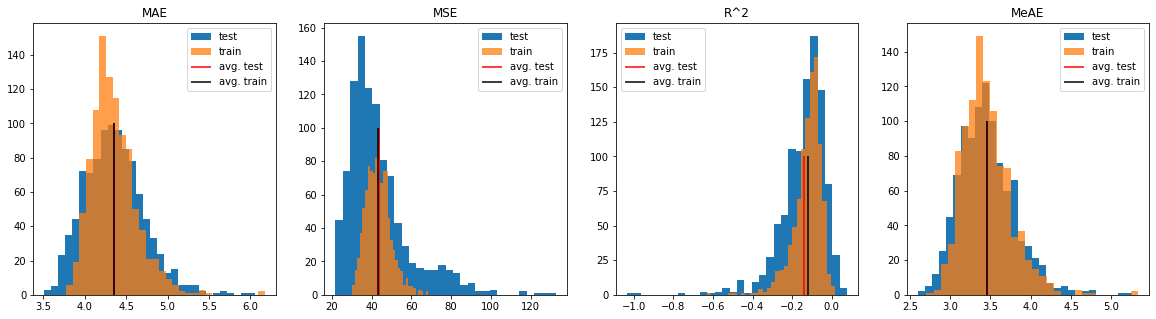

In [49]:
train_df_33 = pd.DataFrame(train_metrics_33, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_33 = pd.DataFrame(test_metrics_33, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_33, test = test_df_33, k=4, p=4)

In [50]:
normtest(train_df_33)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  4.927162e-20  0.937711            1   4.353756   4.312525     NO
1    MSE  1.070271e-11  0.976314            1  43.395139  43.001957     NO
2    R^2  4.287028e-25  0.899260            1  -0.121122  -0.107767     NO
3   MeAE  2.604954e-18  0.947890            1   3.453015   3.411585     NO

In [51]:
normtest(test_df_33)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  8.663392e-11  0.979124            1   4.357793   4.329067     NO
1    MSE  2.194238e-29  0.854384            1  43.511831  39.567081     NO
2    R^2  1.200151e-27  0.874108            1  -0.142259  -0.118380     NO
3   MeAE  2.207742e-13  0.970470            1   3.460203   3.434195     NO

None of the distributions are normal

General notes on the performance metrics: as with OLS, the NN appears not to be a good model for predicting Real GDP Growth the next year with the current independent variables. High errors (taking into account we are estimating percent change) and low variance explained. NN performs form when assesed only by the average performance metric of the test set.

### Random Forest

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [70]:
forest = RandomForestRegressor(n_estimators = 100, max_depth = 5)

Random forests protect against overfitting by construction through bootstrapping. Even if one would want to get an estimate on the model’s capability to generalize, a commonly used approach is to get out-of-bag error estimates: by using the mean prediction error for a training sample using only the trees that did not have this sample in their bootstrap.

As such, the requirement to construct a validation set to perform an unbiased evaluation might not be as strict for random forests as is the case for other techniques, which in fact highlights the great performance and generalization properties of the technique. This being said, it still is a good idea to nevertheless construct a validation set, i.e. in the following cases:

#### 75% training size

In [71]:
%%time
train_metrics_41 = []
test_metrics_41 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.75)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics(X_train, y_train, X_test, y_test, forest)
    train_metrics_41.append(temp_matrix[0])
    test_metrics_41.append(temp_matrix[1])

Wall time: 19min 37s


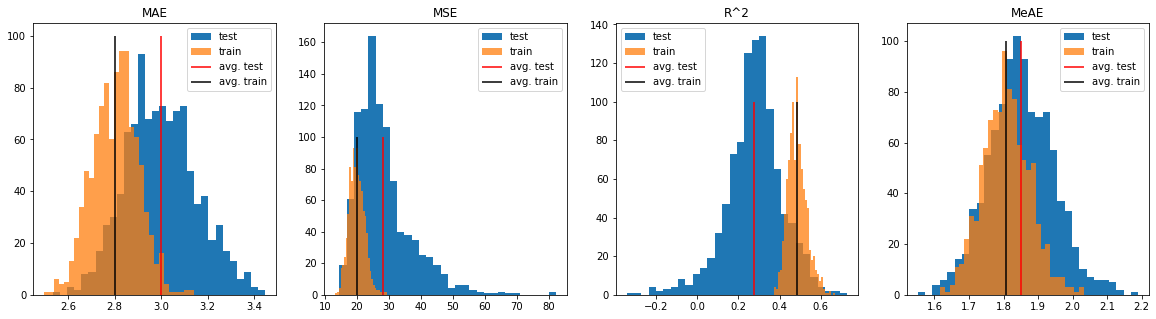

In [73]:
train_df_41 = pd.DataFrame(train_metrics_41, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_41 = pd.DataFrame(test_metrics_41, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_41, test = test_df_41, k=4, p=4)

In [74]:
normtest(train_df_41)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  2.519986e-01  0.997923            0   2.802992   2.807360    YES
1    MSE  3.327165e-05  0.992064            1  19.960533  19.878218     NO
2    R^2  2.716401e-09  0.983282            1   0.485743   0.482931     NO
3   MeAE  1.138306e-01  0.997419            0   1.807528   1.805372    YES

In [75]:
normtest(test_df_41)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  1.212137e-02  0.996061            1   2.999143   2.992567     NO
1    MSE  5.061290e-27  0.880669            1  28.326330  26.190781     NO
2    R^2  6.168473e-12  0.975535            1   0.277504   0.283382     NO
3   MeAE  1.496419e-01  0.997589            0   1.851200   1.847656    YES

MAE and MeAE show normality in the train set and MeAE shows normality in the test set.

#### 50% training size

In [76]:
%%time
train_metrics_42 = []
test_metrics_42 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.50)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics(X_train, y_train, X_test, y_test, forest)
    train_metrics_42.append(temp_matrix[0])
    test_metrics_42.append(temp_matrix[1])

Wall time: 13min 28s


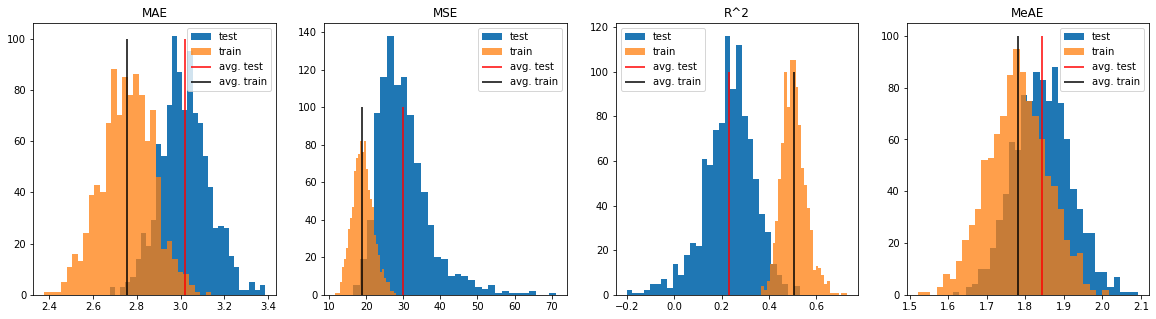

In [77]:
train_df_42 = pd.DataFrame(train_metrics_42, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_42 = pd.DataFrame(test_metrics_42, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_42, test = test_df_42, k=4, p=4)

In [78]:
normtest(train_df_42)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  5.103793e-01  0.998431            0   2.756157   2.759157    YES
1    MSE  3.610522e-04  0.993789            1  18.957036  18.817691     NO
2    R^2  2.222077e-09  0.983055            1   0.504778   0.501450     NO
3   MeAE  7.466463e-01  0.998787            0   1.780028   1.780999    YES

In [79]:
normtest(test_df_42)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  1.466218e-02  0.996178            1   3.019636   3.013806     NO
1    MSE  1.156307e-24  0.903093            1  30.018600  28.917461     NO
2    R^2  2.121415e-10  0.980260            1   0.231209   0.237587     NO
3   MeAE  6.961423e-01  0.998711            0   1.844713   1.842637    YES

Same as before

#### 90% training size

In [80]:
%%time
train_metrics_43 = []
test_metrics_43 = []
for i in range(1000):
    df9 = X_Y.sample(frac = 1, replace = True)
    X = df9.drop(['Real GDP Growth (T+1)'], axis = 1)
    y = df9['Real GDP Growth (T+1)']
    split = train_test_split(X, y, train_size= 0.90)
    X_train, X_test, y_train, y_test = split
    temp_matrix = run_metrics(X_train, y_train, X_test, y_test, forest)
    train_metrics_43.append(temp_matrix[0])
    test_metrics_43.append(temp_matrix[1])

Wall time: 20min 52s


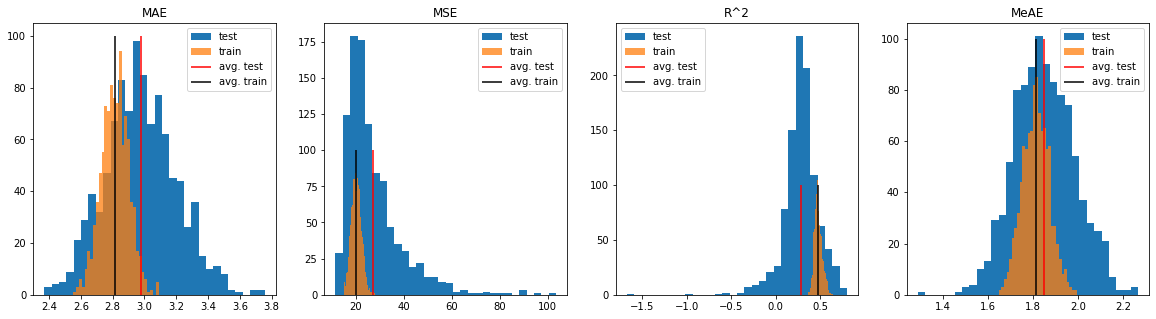

In [81]:
train_df_43 = pd.DataFrame(train_metrics_43, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
test_df_43 = pd.DataFrame(test_metrics_43, columns = ['MAE', 'MSE', 'R^2', 'MeAE'])
metricsplots(train = train_df_43, test = test_df_43, k=4, p=4)

In [82]:
normtest(train_df_43)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  5.965675e-01  0.998563            0   2.814976   2.815476    YES
1    MSE  5.683091e-03  0.995593            1  20.245156  20.194144     NO
2    R^2  3.370648e-09  0.983524            1   0.477004   0.470765     NO
3   MeAE  5.083607e-01  0.998428            0   1.812002   1.811288    YES

In [83]:
normtest(test_df_43)

Metric       P_Value      Stat  reject_null       Mean     Median Normal
0    MAE  5.137724e-02  0.996936            0   2.976802   2.967541    YES
1    MSE  6.242114e-32  0.821209            1  27.106339  23.558572     NO
2    R^2  4.684257e-24  0.908307            1   0.281866   0.291559     NO
3   MeAE  1.623872e-01  0.997640            0   1.849616   1.843394    YES

Same as before but in this case, we also have normality in MAE in the test set.

The Random Forest model outperformed the NN and OLS and it showed normality in some distributions.

### Final Remarks
- The histograms of both the training data and test data performance metrics in most of the training sizes resemble the normal distribution. Nevetheless this is in most ocassions not supported by the normality tests. In the case of the RF as the training size increased the variance of the performance metrics increases for the tests data which is consistent due to the lower number of observations in the tests data but the means of the distributions remain in the similar ranges for all the training sizes.

- In general,after we examine most of the results of tests of normality, we reach the conclusion that there is no converging distribution. While visually the training performance metrics appear normal or converge to normal as the size is increasing, the test performance metrics shows different patterns. We think this is due to the fact that as the training size increases, the test size decreases, and thus the test metrics do not have a properly defined distribution, but further exploration is encouraged by increasing the number of the boostrapping sample (which will require more computational power).

 ## III. Hyopthesis Tests

This section seeks to analyze if the performance metrics found in the three previous models are different from each other. The benefit of having and underlying distribution of the performance metrics is that we can statistically establish with a confidence level if one model performs better than the other based on the performance metrics.

### Plots

Here we will plot the distributions of our performance metrics in order to graphically asses if the mean of our performance metric is different from the other models.

In [84]:
#Compare Plots
def compareplots(reg, neural, forest, title = '% training size'):#insert reg, then neural then forest
    fig, axs = plt.subplots(2, 2, figsize = (20,10))
    end = 1
    for ii in range(2):
        for jj in range(2):
            axs[ii,jj].hist(reg.iloc[:,end-1], bins = 30, label = 'OLS')
            axs[ii,jj].vlines(np.mean(reg.iloc[:, end-1]), 0 , 100, label = 'avg. OLS', color = 'red')
            axs[ii,jj].hist(neural.iloc[:,end-1], bins = 30, label = "NN", alpha = 0.75)
            axs[ii,jj].vlines(np.mean(neural.iloc[:, end-1]), 0 , 100, label = 'avg. NN', color = 'black')
            axs[ii,jj].hist(forest.iloc[:,end-1], bins = 30, label = "RF", alpha = 0.75)
            axs[ii,jj].vlines(np.mean(forest.iloc[:, end-1]), 0 , 100, label = 'avg. RF', color = 'green')
            axs[ii,jj].set_title(forest.columns[end-1])
            axs[ii,jj].legend()
            end = end + 1
    fig.suptitle(title)

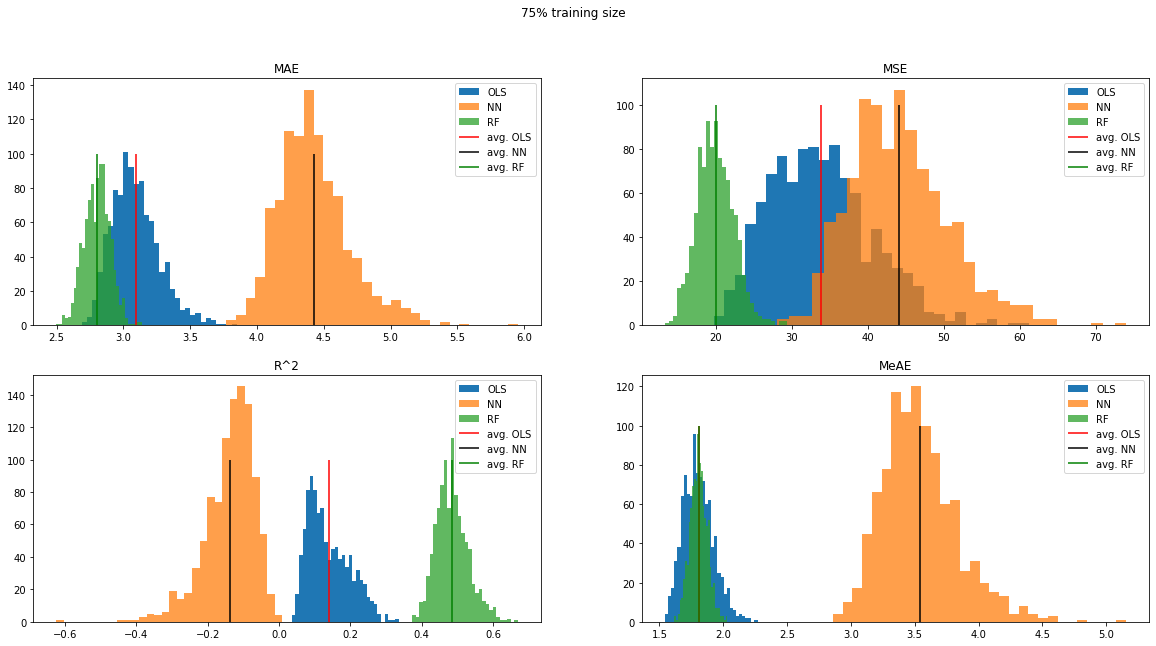

In [85]:
compareplots(train_df_21, train_df_31, train_df_41, '75% training size')

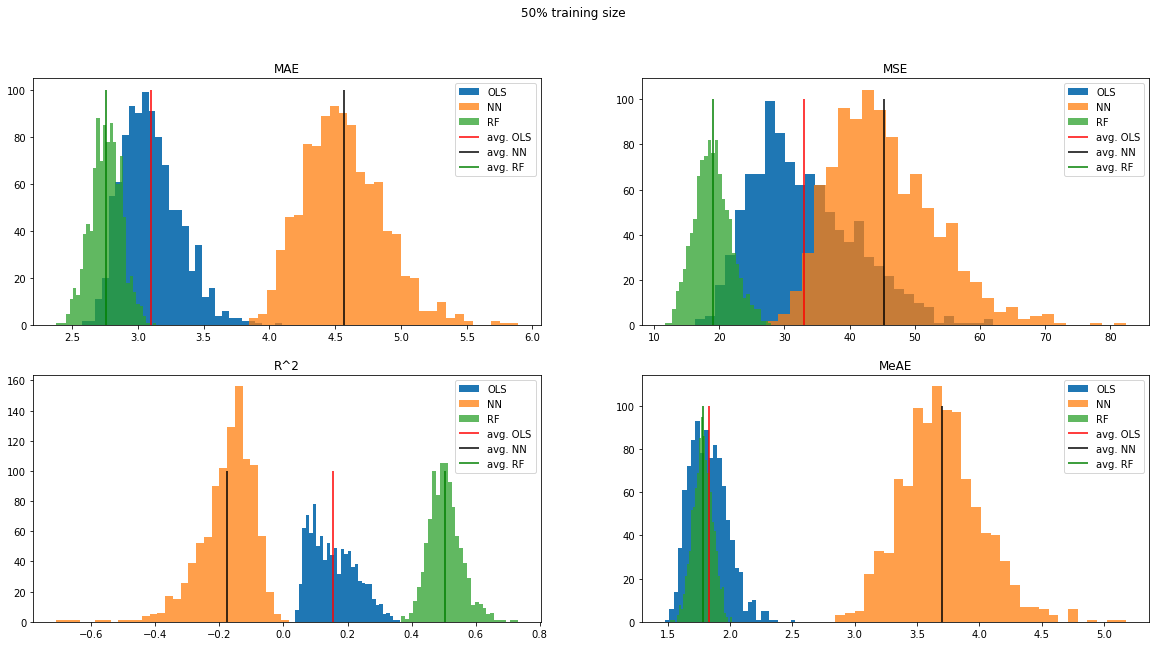

In [86]:
compareplots(train_df_22, train_df_32, train_df_42, '50% training size')

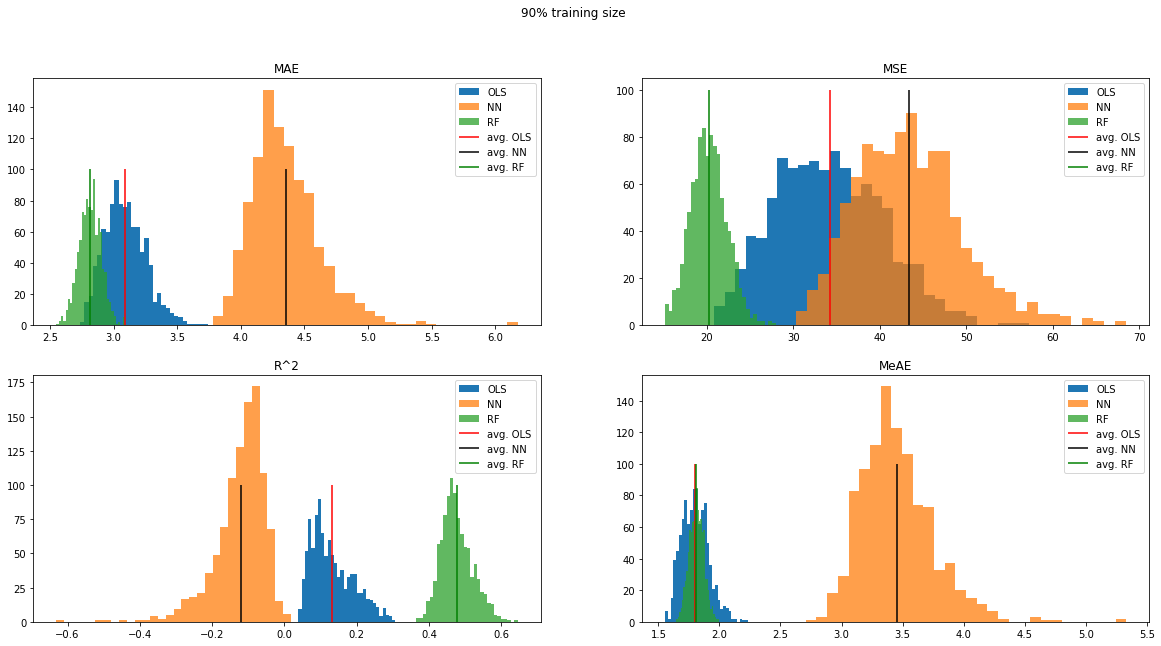

In [87]:
compareplots(train_df_23, train_df_33, train_df_43, '90% training size')

We can infer from the graphs that performance metrics of the models show similar behavior in all the different test sizes. Some distributions are wider than others, the NN shows particualarly a very wide distributions. We can infer that in some performance metrics hypothesis testing will yield that the performance metrics between models are different.

### Tests

In this section we want to compare the means of the performence metrics of the three modesls. In this generla viwe we want to compare it the means of the three performance metrics are different. We will use a one-way ANOVA for this test.

In [89]:
def meantests(reg, neural, forest, alpha):
    p_vals = []
    metrics = []
    statistics = []
    different = []
    for column in reg:
        f,p = stats.f_oneway(reg[column],neural[column],forest[column])
        p_vals.append(p)
        statistics.append(f)
        metrics.append(column)
        if p < alpha:
            different.append("YES")
        else:
            different.append("NO")
    final = pd.DataFrame(list(zip(metrics, p_vals, statistics, different)), 
                         columns = ["Metric", "p", 'ANOVA Statistic', "Different Means"] )
    return final

In [90]:
#75% training size
meantests(train_df_21, train_df_31, train_df_41, 0.05)

Metric    p  ANOVA Statistic Different Means
0    MAE  0.0     19874.672910             YES
1    MSE  0.0      4818.674581             YES
2    R^2  0.0     27968.418423             YES
3   MeAE  0.0     28226.854000             YES

In [91]:
#50% training size
meantests(train_df_22, train_df_32, train_df_42, 0.05)

Metric    p  ANOVA Statistic Different Means
0    MAE  0.0     17825.341389             YES
1    MSE  0.0      3912.854835             YES
2    R^2  0.0     23433.513124             YES
3   MeAE  0.0     26993.793500             YES

In [92]:
#90% training size
meantests(train_df_23, train_df_33, train_df_41, 0.05)

Metric    p  ANOVA Statistic Different Means
0    MAE  0.0     18550.967431             YES
1    MSE  0.0      5052.938505             YES
2    R^2  0.0     27468.992231             YES
3   MeAE  0.0     25798.893606             YES

For further analysis and to choose the best model we could also do individual tests between two performance metrics from two models to asses if the difference they show is significant or not.

Using hypothesis testing could yield a more objective criterion to compare the performance metrics. 
This procedure proposal could be a new criterion to select the best model avoiding bias, in contrast with other criteria that are prone to arbitrariness (K-fold Cross Validation to compare the mean of the performance metrics in the train and test set for example). Further research and exploration are encouraged on this first proposal.